<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Introduction to Point Spread Function (PSF)</b> <br>
Contact author(s): Andrés A. Plazas Malagón<br>
Last verified to run:  08/8/2023 <br>
LSST Science Pipelines version: w_2023_21  <br>
Container Size: medium <br>
Targeted learning level: beginner <br>

**Description:** This tutorial provides a comprehensive guide on Point Spread Function (PSF) properties, including retrieval from catalogs and images, kernel generation, image display, size calculations, wavelength dependence, and diagnostic statistics like correlation functions.


**Skills:** Use of the catalog data products for PSF studies.

**LSST Data Products:**   DP0.2 collection: '2.2i/runs/DP0.2'. Dataset types: 'calexp', 'deepCoadd'.  Catalogs: 'dp02_dc2_catalogs.Object'

**Packages:** lsst.afw.image, lsst.afw.detection, lsst.rsp, lsst.daf.butler, lsst.geom, lsst.afw.display, lsst.analysis.tools, lsst.pipe.base

**Credits:** Developed by Andrés A. Plazas Malagón in collaboration with Melissa Graham and the Rubin Community Science Team for DP0.2. The `ImageExaminer` class to study the PSF image profile and properties is based on the rapid-analysis code to characterize the Rubin Auxiliary Telescope 
LSST Atmospheric Transmission and Slitless Spectrograph (LATISS) images Point Spread Function (PSF), written originally by Merlin Fisher-Levine. The section on PSF size and its correlation function using the software `treecorr` is based on a Jupyter notebook by Claire-Alice Hebert. The Section on PSF size histograms and dependency on central filter wavelength is based on a Jupyter Notebook by Tianqing Zhang. The section on `rho` statistics using `lsst.analaysis.tools` is based on a Jupyter Notebook by Arun Kannawadi.

This notebook has made used of suggestions in the [Accessible Authoring Checklist](https://iota-school.github.io/accessibility_hackathon/hack#checklist)


**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

# The Point Spread Function (PSF)

## Table of contents
1.  Introduction.

    1.1. Package imports.
    
    1.2 Functions and Parameters Definitions.
    
2.  PSF image manipulation in `calexp` and `deepCoadd` images.

    2.1 PSF in `calexp` images.
    
    2.2 PSF in `deepCoadd` images.
    
    2.3 PSF properties for rapid analysis.
    
3. Size of the PSF and its correlation function using `treecorr`.

    3.1 Cone Search around the DC2 center using the `Object` catalog.
    
    3.2 Size calculation, visualization, and two-point correlation function calculation. 
    
4. Wavelength dependence of seeing.

5. Rho statistics with `analysis_tools`.


## 1. Introduction


In the context of astronomical surveys such as the Vera C. Rubin Legacy Survey of Space and Time (LSST), an important objective is to extract cosmological information by studying subtle deviations in the shapes and orientations of galaxies caused by gravitational lensing from large-scale structures in the foreground. However, the observed shapes of galaxies are not solely influenced by the gravitational lensing effects of the universe's large-scale structure (referred to as "cosmic shear"), but also by a combined blurring effect known as the point spread function (PSF). The PSF arises from various factors such as atmospheric conditions (for ground-based instruments), telescope optics, and the image sensor.

The PSF can be understood as a function that describes how a bundle of rays, which would initially converge on a single point, spreads out spatially around that point. To accurately characterize the PSF, it is common to analyze the observed images of stars, which act as point sources before being distorted by the PSF. This analysis helps determine the convolution kernel, representing the size and shape of the blurring effect caused by the PSF. It is crucial to model the PSF accurately because any inaccuracies can lead to erroneous conclusions about fundamental aspects of the universe, such as the properties of dark matter and dark energy. Therefore, understanding and characterizing the PSF is essential in order to properly interpret and extract reliable cosmological information from astronomical observations.

This tutorial studies the properies of the Point Spread Function using the DP0.2 dataset. It is composed of the following sections: 

 -  Section 2 produces an image of the PSF model at a particular location on `calexp` and `deepCoadd` images. It then shows how to calculate PSF profiles and contours and other properties such as size. 

 - Section 3 calculates and displays the size of the PSF in a particular photometric band (`i`)  as function of sky location, and it computes the size-size two-point correlation function (autocorrelation) using the `treecorr` software, which is widely used in state-of-the-art weak lensing analyses to derive cosmological parameters. 

 - Section 4 illustrates one chromatic depedence of the PSF: the wavelength dependence of the PSF size. 

 - Section 5 calculates the `rho` statistics, a series of two-point correlation functions used to diagnose the quality of a PSF model for weak lensing analyses, using the `lsst.afw.analysis.tools` framework. 


#### Additional resources

Review article: [Point spread function modelling for
astronomical telescopes: a review focused on
weak gravitational lensing studies](https://arxiv.org/pdf/2306.07996.pdf)

<a href="https://rmjarvis.github.io/TreeCorr/_build/html/index.html">Treecorr documentation </a>

Chromatic effects of the PSF:

- Impact of Differential Chromatic Refraction (DCR) on weak lensing:  
 [Plazas and Bernstein 2012](https://iopscience.iop.org/article/10.1086/668294/pdfhttps://iopscience.iop.org/article/10.1086/668294/pdf)
    
- Impact of DCR on Supernovae measurements: 
[Lee et al. 2023](https://iopscience.iop.org/article/10.3847/1538-3881/acca15/pdf)
    
- Impact of DCR, wavelength dependence of seeing, and other chromatic effects on weak lensing:
[Meyers and Burchat 2015](https://iopscience.iop.org/article/10.1088/0004-637X/807/2/182/meta)

PSF modeling and null tests for galaxy surveys, including `rho` statistics:

-  [Dark Energy Survey Y3 results: point spread function modeling](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract)
-  [The three-year shear catalog of the Subaru Hyper Suprime-Cam SSP Survey](https://ui.adsabs.harvard.edu/abs/2022PASJ...74..421L/abstract)

PSF in coadded images: 

- [Mandelbaum et al. 2022](https://arxiv.org/pdf/2209.09253.pdf)


### 1.1. Package Imports

The [matplotlib](https://matplotlib.org/) (and especially sublibrary `matplotlib.pyplot`), [numpy](http://www.numpy.org/), [scipy](https://scipy.org/https://scipy.org/), and [astropy](http://www.astropy.org/) libraries are widely used Python libraries for plotting, scientific computing, scientific analysis, and astronomical data analysis.

The `lsst.rsp` package provides access to the Table Access Protocol (TAP) service for queries to the DP0 catalogs.

The `lsst.afw.image` provide visualization tools.

The `lsst.afw.display` library provides access to image visualization routines and the `lsst.daf.butler` library is used to access data products via the butler.

The `lsst.afw.analysis.tools` library provides acces to analysis tools.

The `lsst.geom` library provides the representation of a 2D coordinate `Point2D`.

The `lsst.pipe.base` library provides access to the `lsst.pipe.base.Struct` container.

[treecorr](https://rmjarvis.github.io/TreeCorr/_build/html/index.html) by [Jarvis et al. 2004](https://ui.adsabs.harvard.edu/abs/2004MNRAS.352..338J/abstract) is a widely used tool for fast correlations measurements based on a ball tree method (similar to a k-d tree). In particular, it is widely used in state-of-the-art weak lensing cosmological analyses. 

In [1]:
%load_ext pycodestyle_magic
%flake8_on
import logging
logging.getLogger("flake8").setLevel(logging.FATAL)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import treecorr
from scipy.optimize import curve_fit
from matplotlib import cm
from numpy.linalg import norm
from matplotlib.ticker import LinearLocator
from matplotlib.offsetbox import AnchoredText

import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
import lsst.pipe.base as pipeBase
from lsst.rsp import get_tap_service
from lsst.geom import Point2D
from lsst.analysis.tools.atools import RhoStatistics

### 1.2 Functions and Parameters Definitions

The following cell will set a standard figure size and `afwDisplay` backend to use throughout the notebook.

In [3]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

The following hidden cell defines the convertion factor between the standard deviation of a one-dimensional Gaussian profile and its full-width at half maximum (FWHM), a function with a one-dimensional Gaussian profile, and the class `ImageExaminer` that will be used in section 2.3 "PSF properties for rapid analysis" to examine the image of the Point Spread Function at a particular point. The class is based on the [class of the same name](https://github.com/lsst-sitcom/summit_utils/blob/main/python/lsst/summit/utils/imageExaminer.py) written by Merlin Fisher-Levine for rapid [analysis of the images](https://roundtable.lsst.codes/rubintv/summit/auxtel/im_current) taken by the Rubin Auxiliary Telescope with the LATISS instrument, and it contains a series of methods defined to produce, for example, contour, surface, and radial plots, and calculate certain statistics of interest such as the PSF size (for particular definitions of size).  

To see the contents of the hidden cell, select View from the menu bar and then Expand Selected Code, or click on the vertical next to the cell or on the three dots that denote that the cell is hidden.

In [29]:
SIGMATOFWHM = 2.0*np.sqrt(2.0*np.log(2.0))


def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


class ImageExaminer():
    """Class to examine PSF image properties.
    This is a simplified version---with minor modifications---of the
    code in
    https://github.com/lsst-sitcom/summit_utils/blob/main/python/lsst/summit/utils/imageExaminer.py
    """
    cutoutMappings = {"fitAmp": "Radial fitted amp",
                      "fitGausMean": "Radial fitted position",
                      "fitFwhm": "Radial fitted FWHM",
                      "eeRadius50": "50% flux radius",
                      "eeRadius80": "80% flux radius",
                      "eeRadius90": "90% flux radius"}

    def __init__(self, exp, *, centroid=None, boxHalfSize=None):
        self.exp = exp
        self.centroid = centroid
        self.data = exp.array
        xlen, ylen = self.data.shape
        if centroid is None:
            self.centroid = np.array([xlen/2, ylen/2])
        else:
            self.centroid = centroid
        if boxHalfSize is None:
            self.boxHalfSize = xlen // 2
        else:
            self.boxHalfSize = boxHalfSize
        self.xx, self.yy = self.getMeshGrid(self.data)
        self.imStats = pipeBase.Struct()
        self.radialAverageAndFit()

    def plotSurface(self, ax=None, useColor=True):
        """Make the surface plot.

        Parameters
        ----------
        ax : `maplotlib.axes`, optional.
            If ``None`` a new figure is created. Supply axes
            if including this as a subplot.
        useColor : `bool`, optional.
            Plot at as a surface if ``True``, else plot as a
            wireframe.
        """
        plotDirect = False
        if not ax:
            fig, ax = plt.subplots(subplot_kw={"projection": "3d"},
                                   figsize=(10, 10))
            plotDirect = True

        if useColor:
            _ = ax.plot_surface(self.xx, self.yy, self.data,
                                cmap=cm.plasma, linewidth=1,
                                antialiased=True, color='k', alpha=0.9)
        else:
            _ = ax.plot_wireframe(self.xx, self.yy,
                                  self.data, cmap=cm.gray,  # noqa F841
                                  linewidth=1, antialiased=True, color='k')

        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter('{x:,.0f}')
        ax.set_title("Surface plot")
        ax.set_xlabel('x (pix)')
        ax.set_ylabel('y (pix)')

        if plotDirect:
            plt.show()

    def plotContours(self, ax=None, nContours=10):
        """Make the contour plot.

        Parameters
        ----------
        ax : `maplotlib.axes`, optional
            If ``None`` a new figure is created. Supply axes
            if including this as a subplot.
        nContours : `int`, optional
            The number of contours to use.
        """
        plotDirect = False
        if not ax:
            fig = plt.figure(figsize=(8, 8))  # noqa F841
            ax = plt.subplot(111)
            plotDirect = True

        vmin = np.percentile(self.data, 0.1)
        vmax = np.percentile(self.data, 99.9)
        lvls = np.linspace(vmin, vmax, nContours)
        _ = ax.contour(self.xx, self.yy,
                       self.data, levels=lvls)

        ax.tick_params(which="both", direction="in",
                       top=True, right=True, labelsize=8)
        ax.set_aspect("equal")
        ax.set_title("Contour plot")
        ax.set_xlabel('x (pix)')
        ax.set_ylabel('y (pix)')

        if plotDirect:
            plt.show()

    def plotRowColSlices(self, ax=None):
        """Make the row and column slice plot.

        Parameters
        ----------
        ax : `maplotlib.axes`, optional
            If ``None`` a new figure is created. Supply axes
            if including this as a subplot.
        """
        rowSlice = self.data[self.boxHalfSize, :]
        colSlice = self.data[:, self.boxHalfSize]

        plotDirect = False
        if not ax:
            ax = plt.subplot(111)
            plotDirect = True

        xs = range(-1*self.boxHalfSize, self.boxHalfSize+1)
        ax.plot(xs, rowSlice, '--', label='Row plot')
        ax.plot(xs, colSlice, label='Column plot')
        ax.set_ylabel('Flux (ADU)')
        ax.set_xlabel('Radius (pix)')
        ax.set_aspect(1.0/ax.get_data_ratio(),
                      adjustable='box')
        ax.legend()
        ax.set_title("PSF slices")
        if plotDirect:
            plt.show()

    def plotRadialAverage(self, ax=None):
        """Make the radial average plot.

        Parameters
        ----------
        ax : `maplotlib.axes`, optional
            If ``None`` a new figure is created. Supply axes
            if including this as a subplot.
        """
        plotDirect = False
        if not ax:
            ax = plt.subplot(111)
            plotDirect = True

        distances = self.radialDistances
        values = self.radialValues
        pars = (self.imStats.fitAmp,
                self.imStats.fitGausMean,
                self.imStats.fitFwhm / SIGMATOFWHM)

        fitFailed = np.isnan(pars).any()

        ax.plot(distances, values, 'x', label='Radial average')
        if not fitFailed:
            fitline = gauss(distances, *pars)
            ax.plot(distances, fitline, label="Gaussian fit")

        ax.set_ylabel('Flux (ADU)')
        ax.set_xlabel('Radius (pix)')
        ax.set_aspect(1.0/ax.get_data_ratio(),
                      adjustable='box')  # equal aspect for non-images
        ax.legend()
        ax.set_title("Azimuthally-averaged radial profile.")

        if plotDirect:
            plt.show()

    def radialAverageAndFit(self):
        """Calculate flux vs radius from the star's centroid and fit the width.

        Calculate the flux vs distance from the star's
        centroid and fit a Gaussian to get a measurement of the width.

        Also calculates the various encircled energy metrics.

        Notes
        -----
        Nothing is returned, but sets many value in the class.
        """
        xlen, ylen = self.data.shape
        center = np.array([xlen/2, ylen/2])
        distances = []
        values = []

        for i in range(xlen):
            for j in range(ylen):
                value = self.data[i, j]
                dist = norm((i, j) - center)
                if dist > xlen//2:
                    # clip to box size, we don't need a factor
                    # of sqrt(2) extra
                    continue
                values.append(value)
                distances.append(dist)

        peakPos = 0
        amplitude = np.max(values)
        width = 10

        bounds = ((0, 0, 0), (np.inf, np.inf, np.inf))

        try:
            pars, pCov = curve_fit(gauss, distances, values,
                                   [amplitude, peakPos, width],
                                   bounds=bounds)
            pars[0] = np.abs(pars[0])
            pars[2] = np.abs(pars[2])
        except RuntimeError:
            pars = None
            self.imStats.fitAmp = np.nan
            self.imStats.fitGausMean = np.nan
            self.imStats.fitFwhm = np.nan

        if pars is not None:
            self.imStats.fitAmp = pars[0]
            self.imStats.fitGausMean = pars[1]
            self.imStats.fitFwhm = pars[2] * SIGMATOFWHM

        self.radialDistances = distances
        self.radialValues = values

        # calculate encircled energy metric too
        # sort distances and values in step by distance
        d = np.array([(r, v) for (r, v) in sorted(zip(self.radialDistances,
                                                      self.radialValues))])
        self.radii = d[:, 0]
        values = d[:, 1]
        self.cumFluxes = np.cumsum(values)
        self.cumFluxesNorm = self.cumFluxes/np.max(self.cumFluxes)
        self.imStats.eeRadius50 = self.getEncircledEnergyRadius(50)
        self.imStats.eeRadius80 = self.getEncircledEnergyRadius(80)
        self.imStats.eeRadius90 = self.getEncircledEnergyRadius(90)

        return

    def plotCurveOfGrowth(self, ax=None):
        """Make the encircled energy plot.

        Parameters
        ----------
        ax : `maplotlib.axes`, optional
            If ``None`` a new figure is created. Supply axes
            if including this as a subplot.
        """
        plotDirect = False
        if not ax:
            ax = plt.subplot(111)
            plotDirect = True

        ax.plot(self.radii, self.cumFluxesNorm, markersize=10)
        ax.set_ylabel('Encircled flux (%)')
        ax.set_xlabel('Radius (pix)')

        ax.set_aspect(1.0/ax.get_data_ratio(),
                      adjustable='box')  # equal aspect for non-images
        ax.set_title("Encircled flux")

        if plotDirect:
            plt.show()

    def plotStats(self, ax, lines):
        """Make the stats box 'plot'.

        Parameters
        ----------
        ax : `maplotlib.axes`
            Axes to use.
        lines : `list` of `str`
            The data to include in the text box
        """
        text = "\n".join([line for line in lines])

        stats_text = AnchoredText(text, loc="center", pad=0.5,
                                  prop=dict(size=14, ma="left",
                                            backgroundcolor="white",
                                            color="black", family='monospace'))
        ax.add_artist(stats_text)
        ax.axis('off')

    def getStarBoxData(self):
        """Get the image data for the star.

        Calculates the maximum valid box, and uses that
        to return the image data, setting self.starBbox
        as this method changes the bbox.

        Returns
        -------
        data : `np.array`
            The image data
        """
        bbox = self._calcBbox(self.centroid)
        self.starBbox = bbox  # needed elsewhere, so always set when calculated

        return self.exp.image[bbox].array

    def getMeshGrid(self, data):
        """Get the meshgrid for a data array.

        Parameters
        ----------
        data : `np.array`
            The image data array.

        Returns
        -------
        xxyy : `tuple` of `np.array`
            The xx, yy as calculated by np.meshgrid
        """
        xlen, ylen = data.shape
        xx = np.arange(-1*xlen/2, xlen/2, 1)
        yy = np.arange(-1*ylen/2, ylen/2, 1)
        xx, yy = np.meshgrid(xx, yy)
        return xx, yy

    def getEncircledEnergyRadius(self, percentage):
        """Radius in pixels with the given percentage of
            encircled energy.

        100% is at the boxHalfWidth dy definition.

        Parameters
        ----------
        percentage : `float` or `int`
            The percentage threshold to return.

        Returns
        -------
        radius : `float`
            The radius at which the ``percentage`` threshold
            is crossed.
        """
        return self.radii[np.argmin(
            np.abs((percentage/100)-self.cumFluxesNorm))]

    @staticmethod
    def translateStats(imStats, mappingDict):
        """Create the text for the stats box from the stats
            themselves.

        Parameters
        ----------
        imStats : `lsst.pipe.base.Struct`
            A container with attributes containing measurements
            and statistics for the image.
        mappingDict : `dict` of `str`
            A mapping from attribute name to name for rendereding
            as text.

        Returns
        -------
        lines : `list` of `str`
            The translated lines of text.
        """
        lines = []
        for k, v in mappingDict.items():
            try:
                value = getattr(imStats, k)
            except Exception:
                lines.append("")
                continue

            if type(value) == float or isinstance(value, np.floating):
                value = f"{value:,.3f}"
            if k == 'centroid':  # special case the only tuple
                value = f"{value[0]:.1f}, {value[1]:.1f}"
            lines.append(f"{v} = {value}")
        return lines

### 2. PSF image manipulation in `calexp` and `deepCoadd` images.

The first step in processing LSST science observations is Instrument Signature Removal(ISR). This involves basic detrendings such as flat-fielding, bias subtraction, fringe correction, and fixing bad and saturated pixels. Next, we work on single-epoch direct image characterization, creating models that describe the observational system and how it transforms the true sky into the observed image. This includes background subtraction, PSF modeling, dealing with cosmic rays, applying aperture corrections, and measuring sources. After star-galxy separation, the PSF model in single-epoch images is constructed using images from a star catalog.  the LSST Science Pipelines  now use PSf in the Full-Field of View, PIFF, code instead of PSFEx. The PSF coaddition is currently done in a somewhat simplified way that is not completely optimal for weak lensing science. When the PSF model is requested at a certain point in a coadded image, all the PSF models from the single-epoch images used to create that coadd are combined with the same weights that were used for producing the coadded image. The LSST Science Pipelines are implementing a more robust and well-defined PSF coaddition process (see Mandelbaum ...), measured from coadded regions known as "cell-coads" (see Sheldon et al).

In what follows, we'll create an image of the PSF model at a particular location in a `calexp` and a `deepCoadd` image.  

#### 2.1 PSF in `calexp` images.

Define the Butler instance for DP0.2 and select a particular `calexp` image. We will pass the `visit` and `detector` numbers in order to uniquely constrain the image, and will visualize the imaga afterwards.

In [5]:
config = 'dp02'
collections = '2.2i/runs/DP0.2'
butler = dafButler.Butler(config, collections=collections)

The following cell may produce a warning that reads:

`/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-6.0.0/Linux64/afw/ge482522685+44c69aaa44/python/lsst/afw/image/_exposureSummaryStats.py:157: FutureWarning: Could not read summary fields [decl]. Please use a newer stack.
  warnings.warn(`
  
This warning can be ignored.

In [6]:
datasetType = 'calexp'
dataId = {'visit': 192350, 'detector': 175}
calexp = butler.get(datasetType, dataId=dataId)

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-6.0.0/Linux64/afw/ge482522685+44c69aaa44/python/lsst/afw/image/_exposureSummaryStats.py:157: FutureWarning: Could not read summary fields [decl]. Please use a newer stack.
  warnings.warn(


The following plot is a 2D image of the `calexp` from the previous butler query, in pixel coordinates ranging from 0 to 4000 pixels in both axes, and with a contrast bar ranging from -300 to 400 digital units. Point and extended sources are scattered around the image. We will retrieve PSF models at particular points in this image.

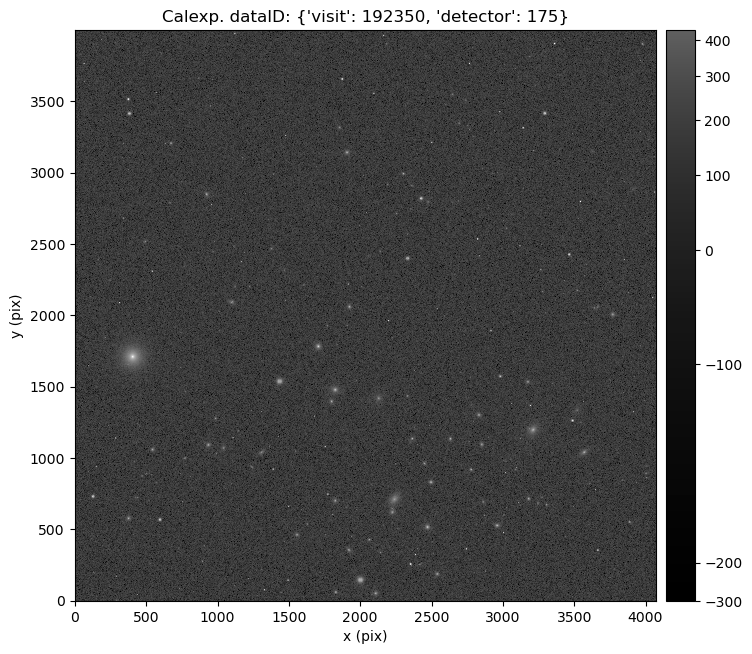

In [7]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(calexp.image)
plt.title(f'Calexp. dataID: {dataId}')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.show()

We will use `computeKernelImage` to display the pixel-based model of the PSF at a particular point. 

In [8]:
point_tuple = (2000, 3500)
point_image = Point2D(point_tuple)

In [9]:
info_calexp = calexp.getInfo()
psf_calexp = info_calexp.getPsf()
psf_calexp_kernel = psf_calexp.computeKernelImage(point_image)
first_psf_image_calexp = psf_calexp_kernel.convertF()

The following plot shows a postage stamp or cut-out of a PSF model from a `calexp`, obtained using `computeKernelImage`. The PSF is centered around zero, and the stamp is rectangular, with a size of 40 pixels, ranging from -20 to 20 pixels on each size. The contrast bar ranges from --0.0002 to about 0.0003. 

(-20.5, 20.5, -20.5, 20.5)

<Figure size 1000x800 with 0 Axes>

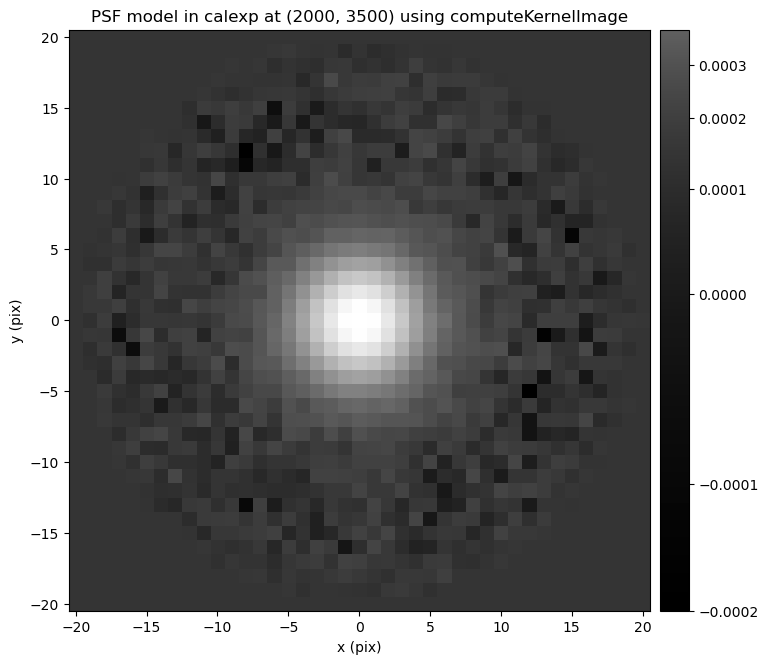

In [10]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(first_psf_image_calexp)
plt.title(f'PSF model in calexp at {point_image} using computeKernelImage')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.gca().axis('on')

Note how the coordinates of the image have their origin at the center of the image.
The coordinates of the origin are (0,0), so the lower left point has negative
coordinates:

In [11]:
print(first_psf_image_calexp.getXY0())

(-20, -20)


Now, instead of `computeKernelImage`, we'll use
`computeImage`. 
One has the PSF center at the center of the 
central pixel in the stamp or cutout (computeKernelImage), and 
the other one (computeImage) can make it at any arbitrary location. In order to accomplish this, we will need the astrometric solution (i.e., the map from pixel to sky coordinates), which, for historical reasons, is denoted as "Wolrd Coordinate System" (WCS) in the code.

In [12]:
wcs_calexp = info_calexp.getWcs()
x, y = point_tuple
second_psf_image_calexp = psf_calexp.computeImage(
    wcs_calexp.skyToPixel(wcs_calexp.pixelToSky(x, y))).convertF()

The following plot shows a postage stamp or cut-out of a PSF model from a `calexp`, obtained using `computeKernelImage`. The PSF is centered around zero, and the stamp is rectangular, with a size of 40 pixels, ranging from -20 to 20 pixels on each size. The contrast bar ranges from --0.0002 to about 0.0003. 

(1979.5, 2020.5, 3479.5, 3520.5)

<Figure size 1000x800 with 0 Axes>

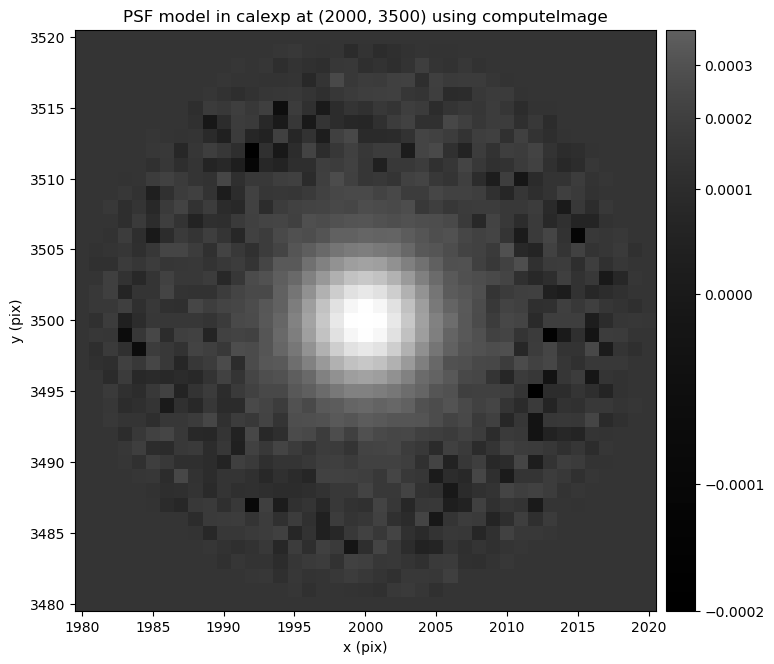

In [13]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(second_psf_image_calexp)
plt.title(f'PSF model in calexp at {point_image} using computeImage')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.gca().axis('on')

In [14]:
print(second_psf_image_calexp.getXY0())

(1980, 3480)


Let's now define a helper function to calculate some PSF properties at a particular point:

In [15]:
def get_psf_properties(psf, point):
    """Function to obtain PSF properties.

    Parameters
    ----------
    psf : `lsst.meas.extensions.psfex.PsfexPsf`
        PSF object.
    point : `lsst.geom.Point2D`
        Coordinate where the PSF is being evaluated.

    Returns
    -------
        sigma : `float`
            PSF determinat radius from SDDS adaptive
            moments matrix.
        ap_flux : `float`
            PSF flux from aperture photometry weighted
            by a sinc function.
        peak : `float`
            Peak PSF value.
        av_pos : `lsst.geom.Point2D'
            Average PSF position.
        dims : `lsst.geom.ExtendI`
            PSF postage stamp dimensions.
    """
    sigma = psf.computeShape(point).getDeterminantRadius()
    ap_flux = psf.computeApertureFlux(radius=sigma, position=point)
    peak = psf.computePeak(position=point)
    av_pos = psf.getAveragePosition()
    dims = psf.computeImage(point).getDimensions()

    print(f"PSF size: {sigma:.4} pix \n"
          f"PSF flux from aperture photometry: {ap_flux:.4} \n"
          f"Peak PSF value: {peak:.4} \n"
          f"Average PSF position: {av_pos} \n"
          f"PSF dimensions: {dims} \n")

    return (sigma, ap_flux, peak, av_pos, dims)

In [16]:
props = get_psf_properties(psf_calexp, point_image)

PSF size: 1.612 pix 
PSF flux from aperture photometry: 0.3659 
Peak PSF value: 0.05834 
Average PSF position: (2020.2, 1772.1) 
PSF dimensions: (41, 41) 



#### 2.2 PSF in `deepCoadd` images.

When conducting multi-epoch surveys for static-sky science, the traditional method involves creating coadds. This process entails resampling images from different observations onto a common grid and averaging them to generate a single, deeper image (`deepCoadd`). Additionally, a coadded point spread function (PSF) model is established. It is crucial to handle PSF coadding with care to ensure a well-defined PSF.

One of the challenges in coadding PSFs arises from slight variations observed between PSFs in different visits. Even minor differences make it practically impossible to accurately model the effective PSF of the coadd using coadded star images. Even small positional shifts, known as dithers, used to fill the gaps between charge-coupled devices introduce disruptions in the coadd's effective PSF. As the number of dithers increases, the areas within the coadd with a continuous effective PSF become smaller, making it increasingly unlikely to find stars suitable for PSF modeling in each region. For the Hyper-Suprime Camera survey, [Bosch et al 2019](https://arxiv.org/pdf/1705.06766.pdf) use an approach that involves resampling and combining the existing PSF models from the input images using the same coordinate transformations and weights applied to the image data. The HSC survey analysis pipleine is based on the LSST Science Pipelines code.

[Mandelbaum et al. 2022](https://arxiv.org/pdf/2209.09253.pdf) provide a mathematical framework that helps produce well-defined coadded PSFs. It is important to note that the results obtained using this approach are specifically applicable to static sources. As indicated in footnote 2 on page 4 of [Mandelbaum et al. 2022](https://arxiv.org/pdf/2209.09253.pdf), the coadd PSF for time-varying sources will vary depending on their light curves. For instance, if a variable or transient source appears very bright in just one exposure and faint in all others, its coadd PSF will essentially match that of the exposure where it is bright. This effect may introduce additional challenges for the LSST. The initial survey plan proposed using two 15-second "snaps" combined into a single 30-second exposure for each visit. Whether this approach will be implemented is still under consideration,  but,  if adopted, the issue of PSF for time-varying objects in a coadd becomes relevant even in the process of combining the two snaps.

We will visualize the PSF model as in section 2.1, but now in a`deepCoadd` image. This time, we will pass the `tract` and `patch` numbers, as well as the desired band (`i`) in order to uniquely constrain the image. 

In [17]:
datasetType = 'deepCoadd'
dataId = {'tract': 4431, 'patch': 17, 'band': 'i'}
coadd = butler.get(datasetType, dataId=dataId)

The following plot is a 2D image of the `deepCoadd` from the previous butler query, in pixel coordinates ranging from 12000 to 16000 pixels in the horizaontal axis and 8000 to 12000 pixel sin the vertical axis. The contrast bar ranges from -0.2 to 0.4 digital units. Point and extended sources are scattered around the image, however, a galaxy cluster is particularly prominent inthe lower left part of the image. We will retrieve PSF models at particular points in this image, in a similar way to how it was done in the previous code cells for `calexp` images.

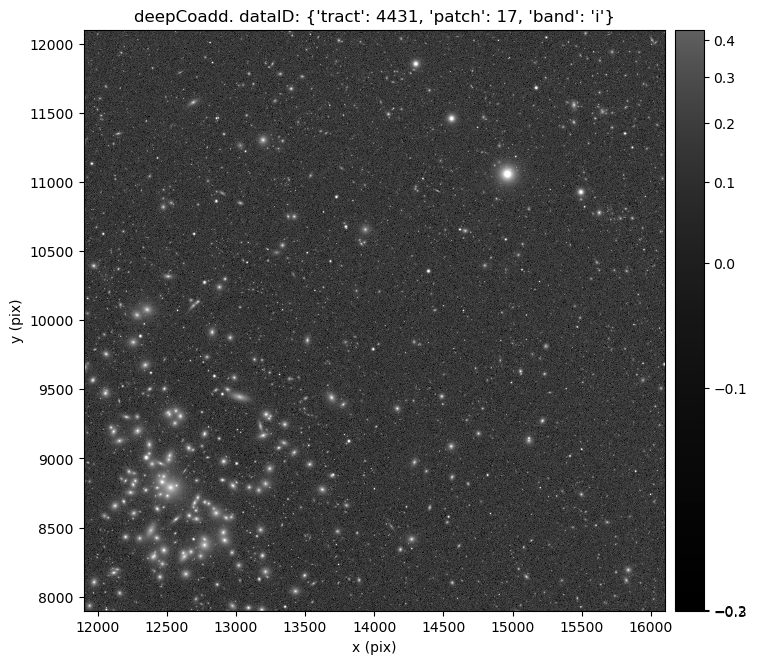

In [18]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(coadd.image)
plt.title(f'deepCoadd. dataID: {dataId}')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.show()

In [19]:
point_tuple = (13000, 8500)
point_image = Point2D(point_tuple)

We will use `computeKernelImage` to display the pixel-based model of the PSF at a particular point. Note the higher signal-to-noise ratio in this image, compared to the single `calexp` PSF image in Section 2.1

In [20]:
info_coadd = coadd.getInfo()
psf_coadd = info_coadd.getPsf()
psf_kernel_coadd = psf_coadd.computeKernelImage(point_image)
first_psf_image_coadd = psf_kernel_coadd.convertF()

The following plot shows a postage stamp or cut-out of a PSF model from a `deepCoadd` image, obtained using `computeKernelImage`. The PSF is centered around zero, and the stamp is rectangular, with a size of about 50 pixels, ranging from -25 to 25 pixels on each size. The contrast bar ranges from -1e-5 to 7e-5 . 

(-28.5, 28.5, -28.5, 28.5)

<Figure size 1000x800 with 0 Axes>

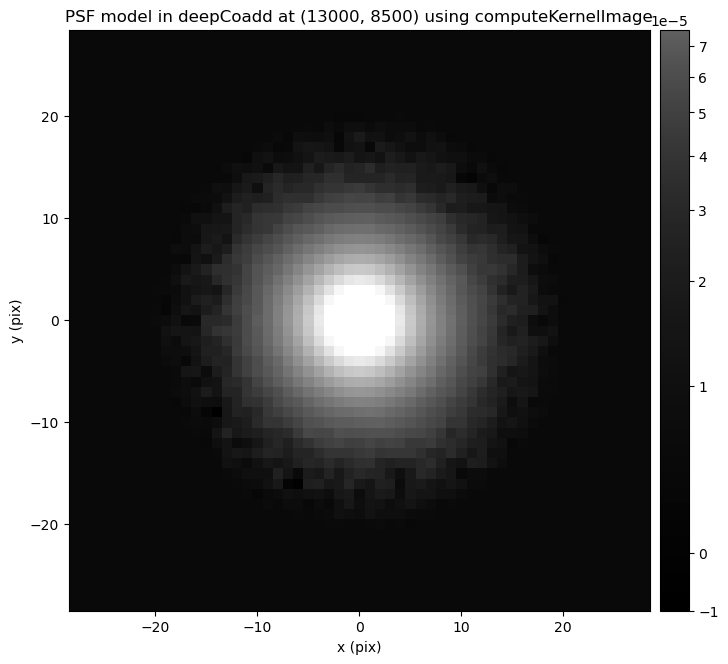

In [21]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(first_psf_image_coadd)
plt.title(f'PSF model in deepCoadd at {point_image} using computeKernelImage')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.gca().axis('on')

Print the coordinates of the origin:

In [22]:
print(first_psf_image_coadd.getXY0())

(-28, -28)


Now, instead of `computeKernelImage`, we'll use
`computeImage`. 
One have the PSF center at the center of the 
central pixel in the stamp or cutout (computeKernelImage), and 
the other one (computeImage) can make it at any arbitrary location.

In [23]:
wcs_coadd = info_coadd.getWcs()
x, y = point_tuple
second_psf_image_coadd = psf_coadd.computeImage(
    wcs_coadd.skyToPixel(wcs_coadd.pixelToSky(x, y))).convertF()

The following plot shows a postage stamp or cut-out of a PSF model from a `deepCoadd` image, obtained using `computeImage`. The PSF is no longer centered around zero as when we used `computKernelImage`, but centered at about 13000 and 8500 pixels. The stamp is still rectangular, with a size of about 50 pixels, ranging from 12970 to 13030 pixels on the horizantal axis and 8470 to 8530 on the vertical axis. The contrast bar ranges from -1e-5 to 7e-5 . 

(12971.5, 13028.5, 8471.5, 8528.5)

<Figure size 1000x800 with 0 Axes>

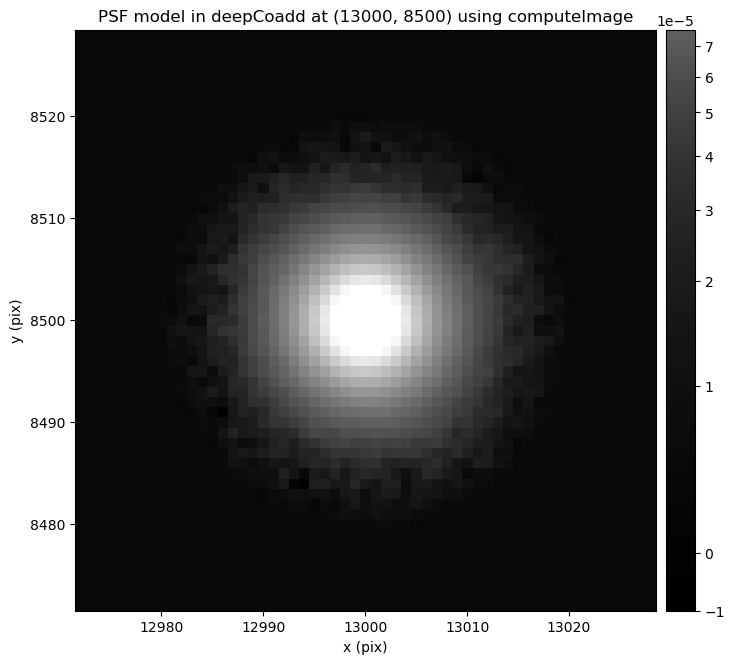

In [24]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(second_psf_image_coadd)
plt.title(f'PSF model in deepCoadd at {point_image} using computeImage')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.gca().axis('on')

Look at the coordinates of the origin:

In [25]:
second_psf_image_coadd.getXY0()

Point2I(12972, 8472)

Calculate the PSF properties, as in Section 2.1 for the `calexp` PSF:

In [26]:
props_psf_coadd = get_psf_properties(psf_coadd, point_image)

PSF size: 1.735 pix 
PSF flux from aperture photometry: 0.3577 
Peak PSF value: 0.04985 
Average PSF position: (13939, 10036) 
PSF dimensions: (57, 57) 



#### 2.3:  PSF properties for rapid analysis.

In this section we will use the `ImageExaminer` class defined in section 1.2 of this tutorial to visualize the `calexp` and `deepCoadd` PSFs from sections 2.1 and 2.2 using surface and contour plots. In addition, we will plot the central PSF one-dimensional profiles along the horizontal and vertical axes, and produce an azimuthally-averaged radial profile of the PSF. We will fit a Gaussian function to this radial profile. Finally, we will also show a plot with the encircled flux as a function of radius, and display the reults of the Gaussian fit to the radial profiile (amplitude, size as Full-Width at Half-Maximum, and centroid) and the 50%, 80%, and 90% encircled fluxes radii. 

This code is based on the class [imageExaminer.py](https://github.com/lsst-sitcom/summit_utils/blob/main/python/lsst/summit/utils/imageExaminer.py), currently used for [rapid PSF analysis of the LATISS images](https://roundtable.lsst.codes/rubintv/summit/auxtel/im_current) taken by Rubin's AuxTel a Cerro Pachón, in Chile. 

The following cell will define a helper function to plot `ImageExaminer` instances. 

In [27]:
def plotPsfImageExaminer(psfImageExaminer):
    """Function to plot `ImageExaminer` instances.

    Parameters
    ----------
    psfImageExaminer: `ImageExaminer`
        `ImageExaminer` object.
    """
    figsize = 6
    fig = plt.figure(figsize=(figsize*2, 3*figsize))

    axSurface = fig.add_subplot(321, projection='3d')
    axContour = fig.add_subplot(322)
    axStats = fig.add_subplot(323)
    axSlices = fig.add_subplot(324)
    axRadial = fig.add_subplot(325)
    axEncircled = fig.add_subplot(326)

    psfImageExaminer.plotSurface(axSurface)
    psfImageExaminer.plotContours(axContour)
    psfImageExaminer.plotRowColSlices(axSlices)
    psfImageExaminer.plotRadialAverage(axRadial)

    lines = []
    lines.append("\n     ---- Cutout ----")
    lines.extend(psfImageExaminer.translateStats(
        psfImageExaminer.imStats,
        psfImageExaminer.cutoutMappings))

    psfImageExaminer.plotStats(axStats, lines)
    psfImageExaminer.plotCurveOfGrowth(axEncircled)

    return

Let's now produce the plots for the`calexp` PSF of section 2.1. We'll start by making an instance of the `ImageExaminer` class.

In [31]:
psfImageExaminerCalexp = ImageExaminer(first_psf_image_calexp)

The following cell will produce a plot with 6 panels, with 3 rows and 2 columns. The upper left plot is a three-dimensional surface plot of the `calexp` PSF in the range of the input postage stamp. The upper right plot is a two-dimensional contour plot with the PSF at the center. The left panel of the middle row contains a summary of statistics that report the amplitude, width, and centroid of a one-dimensional Gaussian fit of the azimuthally averaged radial profile of the PSF. In addition, three encircled flux radii are reported (corresponding to 50%, 80%, and 90% of the encircled flux, respectively). The right panel of the this middle row shows the one-dimensional radial profiles constructed by slicing the 2D PSF image along the center in the horizontal and vertical axes. Finally, the left panel of the final row shows the azimuthally averaged PSF radial profile, along with a curve constructed from the Guassian fit to the data. The right panel shows a monotonically-increasing cumulative plot of the percentage of encircled flux from the center of the PSF profile as a function of radius in pixels. 

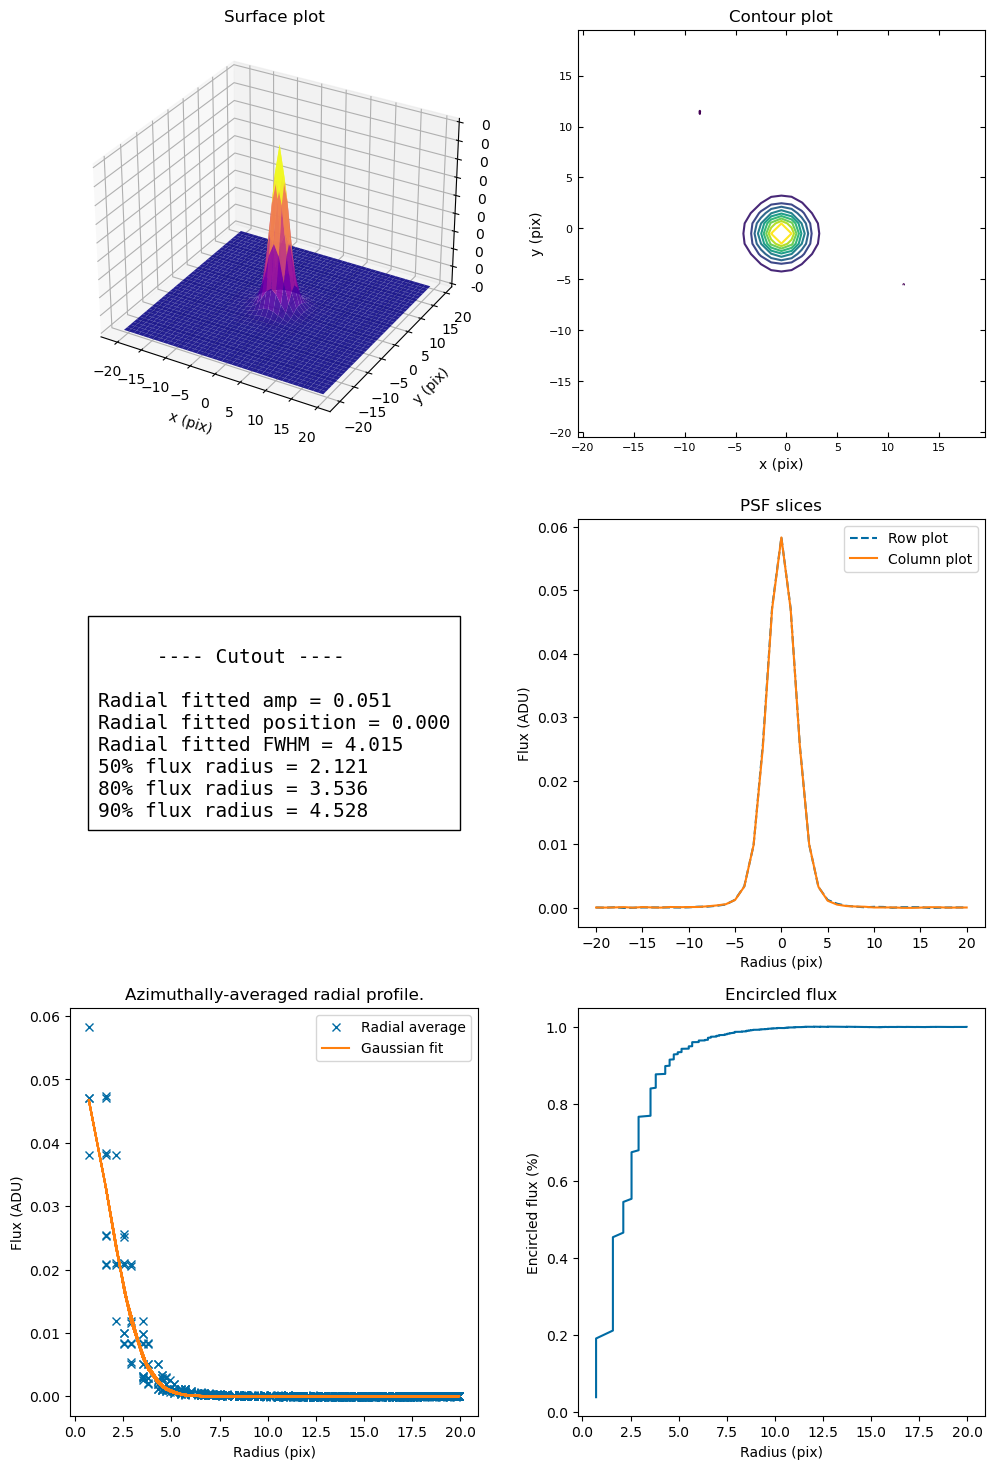

In [32]:
plotPsfImageExaminer(psfImageExaminerCalexp)

And now let's do the plotting for the PSF from the `deppCoadd` of section 2.2.

In [33]:
psfImageExaminerCoadd = ImageExaminer(first_psf_image_coadd)

The following cell will produce a plot with 6 panels, with 3 rows and 2 columns. The upper left plot is a three-dimensional surface plot of the `deepCoadd` PSF in the range of the input postage stamp. The upper right plot is a two-dimensional contour plot with the PSF at the center. The left panel of the middle row contains a summary of statistics that report the amplitude, width, and centroid of a one-dimensional Gaussian fit of the azimuthally averaged radial profile of the PSF. In addition, three encircled flux radii are reported (corresponding to 50%, 80%, and 90% of the encircled flux, respectively). The right panel of the this middle row shows the one-dimensional radial profiles constructed by slicing the 2D PSF image along the center in the horizontal and vertical axes. Finally, the left panel of the final row shows the azimuthally averaged PSF radial profile, along with a curve constructed from the Guassian fit to the data. The right panel shows a monotonically-increasing cumulative plot of the percentage of encircled flux from teh center of the PSF profile as a function of radius in pixels. Since the PSF displayed is a model built from coadded image,s the plots and profiles show higher signa-to-noise ratio compared to the analogous plots from a previous cell made for a `calexp` PSF.

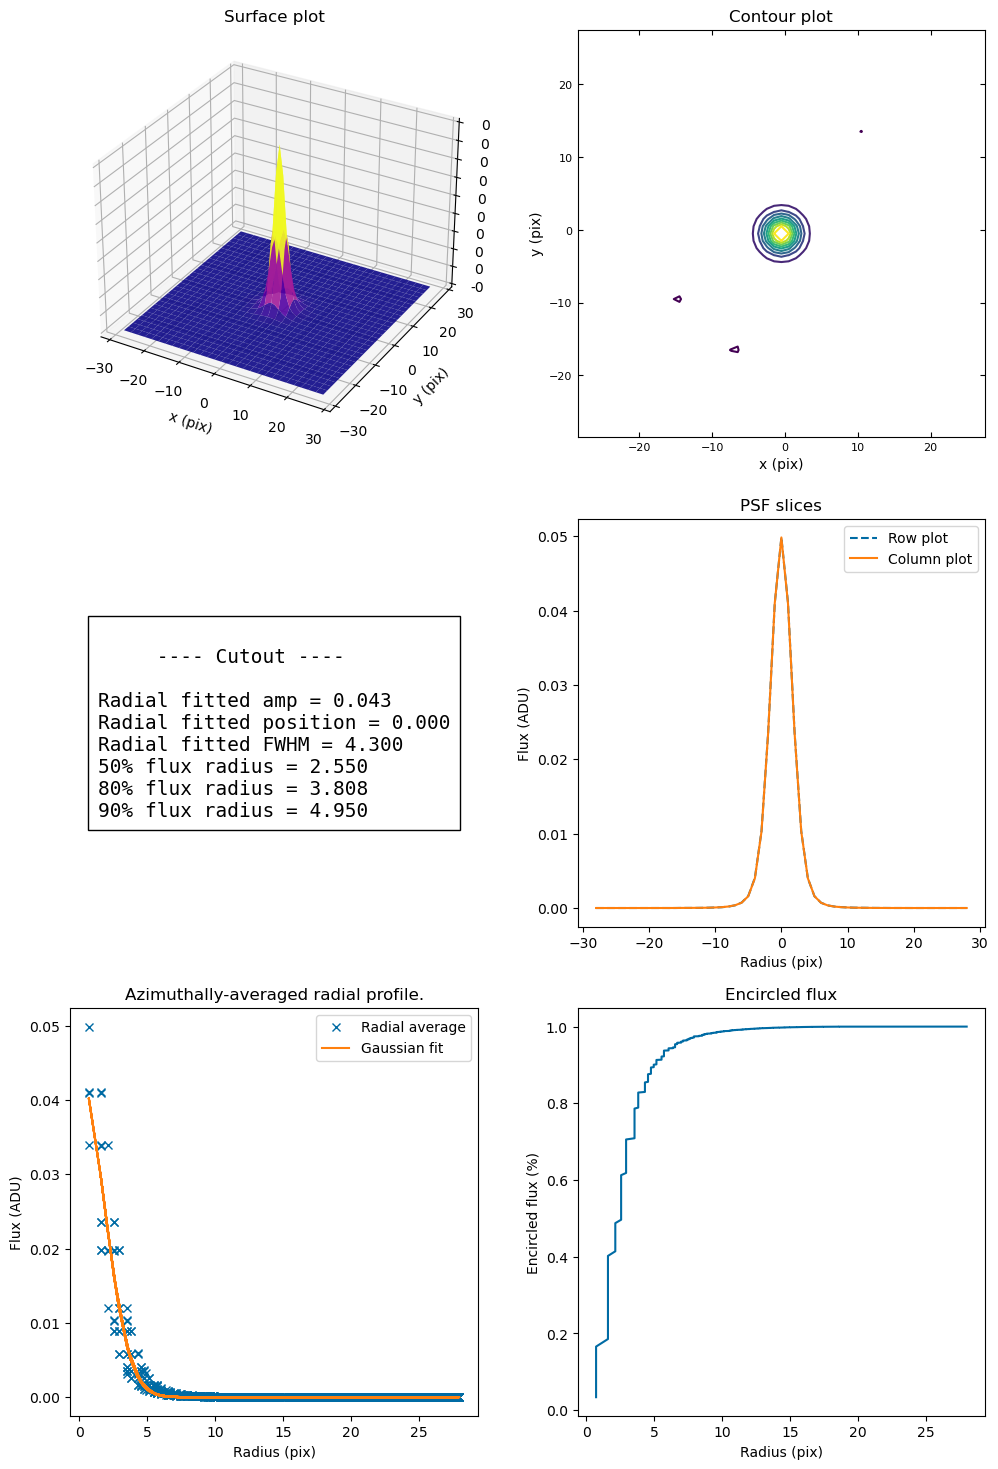

In [34]:
plotPsfImageExaminer(psfImageExaminerCoadd)

#### 3. Size of the PSF and its correlation function using `treecorr`.

In this section we will plot the size of the `deepCoadd` PSF in the `i` band as function of celestial coordinates. We will use the TAP service to retrieve point sources from the `deepCoadd` catalog, along with the necessary quantities. After calculating the PSF size from the modeled PSF second moments, we'll visualize it as a function of sky coordinates. In addition, we will use the `treecorr` software to calculate the two-point correlation function of the size as a funtion of angular separation. Two-point correlations functions are widely used in weak lensign cosmological analysis to infer cosmological parameters, and `treecorr` is the standard tool currently used by many collaborations (e.g., the Dark Energy Survey and the Hyper-Suprime Camera Survey) and by code in the LSST Science Pipelines.

#### 3.1 Cone Search around the DC2 center using the `Object` catalog.  
Let's do a cone search (c.f., NB02) around the DC2 center point, with a search radius of 2 degrees. In the query below, we use the `Object` catalog, which contains the `deepCoadd` objects (see the
<a href="https://dm.lsst.org/sdm_schemas/browser/dp02.html#Object">DP0.2 schema browser</a>). We request the PSF fluxes in different bands, obtained from fitting a PSF model to a selected group of stars. The second moments of the PSF, `{band}_ixxPSF`,`{band}_ixyPSF`, and `{band}_iyyPSF` will be used to calculate the PSF size in each band. In this section we will only plot the size of the PSF in one band (`i`), but section 4 below we will demonstrate the dependency of the PSF size with seeing and, for that, we will use other bands. In order to detect point sources, we set the flags `detect_isPrimary` and `i_extendedness` to 1 and 0.0, respectively. The `i_calib_psf_used` flag ensures that we select stars that were used (as opposed to reserved)  in the determination of the PSF model (see, for example, [Jarvis et al. 2020](https://arxiv.org/abs/2011.03409https://arxiv.org/abs/2011.03409)). The flag `i_pixelFlags_inexact_psfCenter = 0` ensures that the objects are not near edges, because the `EDGE` flag in a `calexp` implies the `SENSOR_EDGE` flag in the `coadd` (if a footprint falls on one of those pixels, it means it has a discontinuous PSF), and `inexact_psfCenter` is formed from an `OR` operation that inclused `SENSOR_EDGE`. The additional queried properties will be used to calculate the `rho` statistics that will be the topic of section 5 of this notebook.

In [35]:
service = get_tap_service("tap")

In [36]:
use_center_coords = "62, -37"
band = 'i'

The following query could take more than a minute.

In [37]:
results = service.search("SELECT TOP 1000000"
                         "coord_ra, coord_dec, "
                         "scisql_nanojanskyToAbMag(u_psfFlux) as u_psfMag, "
                         "scisql_nanojanskyToAbMag(g_psfFlux) as g_psfMag, "
                         "scisql_nanojanskyToAbMag(r_psfFlux) as r_psfMag, "
                         "scisql_nanojanskyToAbMag(i_psfFlux) as i_psfMag, "
                         f"scisql_nanojanskyToAbMagSigma({band}_psfFlux, "
                         f"{band}_psfFluxErr) "
                         f"as {band}_psfMagErr, "
                         f"{band}_psfFlux, "
                         f"{band}_psfFlux_flag, "
                         f"{band}_pixelFlags_saturatedCenter, "
                         f"{band}_extendedness_flag, "
                         "xy_flag, detect_isPatchInner, "
                         "detect_isDeblendedSource, "
                         f"{band}_psfFluxErr, {band}_extendedness, "
                         f"{band}_ixy, {band}_ixyPSF, "
                         "g_ixx, g_iyy, g_ixxPSF, g_iyyPSF, "
                         "r_ixx, r_iyy, r_ixxPSF, r_iyyPSF, "
                         "i_ixx, i_iyy, i_ixxPSF, i_iyyPSF, "
                         "u_ixx, u_iyy, u_ixxPSF, u_iyyPSF  "
                         "FROM dp02_dc2_catalogs.Object "
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                         "CIRCLE('ICRS', "+use_center_coords+", 2.0)) = 1 "
                         "AND detect_isPrimary = 1 "
                         f"AND {band}_calibFlux > 360 "
                         f"AND {band}_extendedness = 0.0 "
                         f"AND {band}_calib_psf_used = 1 "
                         f"AND {band}_pixelFlags_inexact_psfCenter = 0 ")

results_table = results.to_table().to_pandas()

In [38]:
print(len(results_table))

9964


#### 3.2 Size calculation, visualization, and two-point correlation function calculation. 

The trace of the moments matrix in each band, `T = {band}_ixxPSF + {band}_iyyPSF` will be used to calculate the "trace radius" (in pixels) `sqrt(T/2)` of the PSF model in each band, as a mesure of its size. 

In [38]:
results_table['size_g_PSF'] = np.sqrt((results_table['g_ixxPSF']
                                       + results_table['g_iyyPSF']) / 2)
results_table['size_r_PSF'] = np.sqrt((results_table['r_ixxPSF']
                                       + results_table['r_iyyPSF']) / 2)
results_table['size_i_PSF'] = np.sqrt((results_table['i_ixxPSF']
                                       + results_table['i_iyyPSF']) / 2)
results_table['size_u_PSF'] = np.sqrt((results_table['u_ixxPSF']
                                       + results_table['u_iyyPSF']) / 2)

In [39]:
ra = results_table['coord_ra']
dec = results_table['coord_dec']

Let's define `treecorr`'s catalog and adjust a few of its parameters. For more information abotu `treecorr`, check its [documentation](https://rmjarvis.github.io/TreeCorr/_build/html/index.html). 

In [40]:
cat = treecorr.Catalog(ra=ra, dec=dec,
                       k=results_table[f'size_{band}_PSF']
                       - np.mean(results_table[f'size_{band}_PSF']),
                       ra_units='deg', dec_units='deg')

kk_config = {'max_sep': .06, 'min_sep': .0001, 'nbins': 12}


Let's now calculate the two-point correlation function of the size. In this case, this is an auto-correlation (size-size two point correlation):

In [41]:
kk = treecorr.KKCorrelation(kk_config)
kk.process(cat)

Retrieve the correlation function, denoted by `xi`, and the angular separation arrays:

In [42]:
xi = kk.xi
bins = kk.rnom

The figure produced with the following code cell has two panels. The panel on the left displays the PSF size in the searched circle and band, as function of declination (ranging from about -39 to -35 degrees) and right ascention (ranging from about 60 to 64 degrees). The size or PSF trace radius is represented with a color scale at each point that ranges from about 1.68 to 1.78 pixels. The right panel of the figure shows the two-point autocorrelation function of the PSF size as a function of angular separations in degrees. The correlation function values are presented as multiples of 1e4, ranging from -1 to 0, and the angular separation displayed inthe abscisa axis ragnges from 0.01 to 2 degrees, in logarithmic cale. 

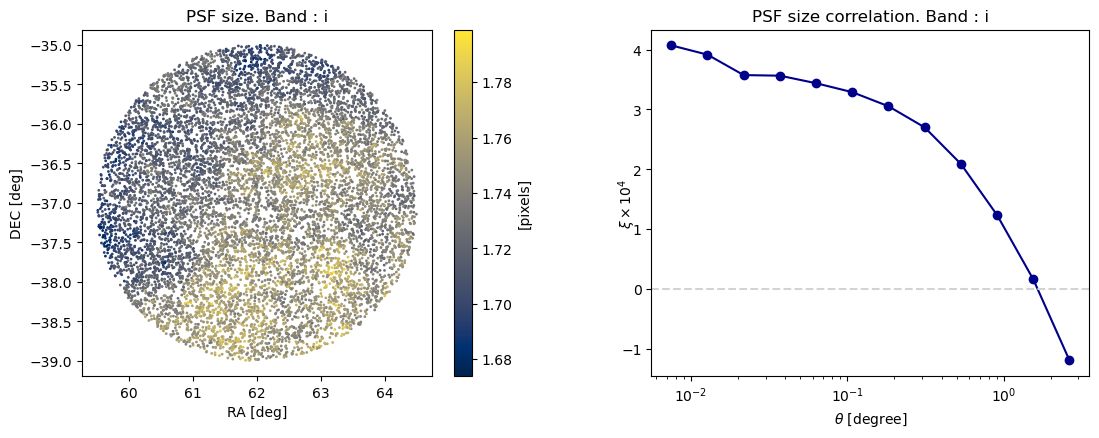

In [43]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5),
                             gridspec_kw={'wspace': .3})

ax1.set_title(f'PSF size. Band : {band}')
scatter_plot = ax1.scatter(ra, dec, c=results_table[f'size_{band}_PSF'],
                           s=1, cmap='cividis')
ax1.set_xlabel('RA [deg]')
ax1.set_ylabel('DEC [deg]')
plt.colorbar(scatter_plot, ax=ax1, label='[pixels]')

ax2.set_title(f'PSF size correlation. Band : {band}')
ax2.plot(np.degrees(bins), xi*1e4, 'o-', color='darkblue')
ax2.axhline(0, linestyle='--', color='lightgrey')
ax2.set_xscale('log')
ax2.set_ylabel(r'$\xi \times 10^{4}$', labelpad=-12)
ax2.set_xlabel(r'$\theta$ [degree]')

plt.show()

### 4. Wavelength dependence of seeing  

In order to correct for the PSF and measure the galaxy shapes to infer the weak lesning signal ("shear"), the PSF is modeled from stars (usually bright stars) and then PSF from the galaxy images is deconvolved using the estimated PSF convolution kernel.  Implicit in this approach is the assumption that the convolution kernel for galaxies is identical to that for stars. However, if the PSF varies with wavelength, this assumption is invalid due to the distinct spectral energy distributions (SEDs) of stars and galaxies, resulting in different PSFs.

In this section, we'll use the sample of point sources retrieved in previous sections to calculate one of the wavelength-dependent contributions to the PSF due to the atmosphere: the wavelength dependence on seeing (other contributions include, for example, Differential Chromatic Refraction).  The standard theory of atmospheric turbulence predicts that the linear size `θ` of the atmospheric convolution kernel (i.e., the seeing) is related to wavelength as `θ ∝ λ**−1/5`.

In order to reproduce this wavelength relationship with our data, we'll start by calculating the central wavelengths of the braodband filters that LSST will use, as well as the mean size and its standard deviation per band. The edges of the filters can be found in Table 2.1 of the [LSST Science Book](https://www.lsst.org/sites/default/files/docs/sciencebook/SB_2.pdf).

In [44]:
wavelength = 0.5*np.array([320+400, 400+552, 552+691, 691+818])

mean_size = [np.mean(results_table['size_u_PSF']),
             np.mean(results_table['size_g_PSF']),
             np.mean(results_table['size_r_PSF']),
             np.mean(results_table['size_i_PSF'])]

std_size = [np.std(results_table['size_u_PSF']),
            np.std(results_table['size_g_PSF']),
            np.std(results_table['size_r_PSF']),
            np.std(results_table['size_i_PSF'])]

We will now fit a power law to the mean PSF size as a function of wavelength.

In [45]:
# Fit size vs wavelength
def power(lam, a, b):
    return a*lam**(-b)


In [46]:
popt, pcov = curve_fit(power, wavelength, mean_size)

In [47]:
lamb_grid = np.arange(300, 800, 1)
fit_size = power(lamb_grid, *popt)
amplitude, exponent = popt
print(f"Amplitude: {amplitude:.3}")
print(f"Exponent: {exponent:.3}")

Amplitude: 6.32
Exponent: 0.196


The fitted exponent, `-0.196`, is close to the expected value of `-1/5=0.2`. 

The following cell will plot the mean PSF size (trace radius in pixels) as function of central wavelength for the LSST filter defined above. A fit to a power law is also displayed, with the amplitude and fitting parameters also shown in the legend.

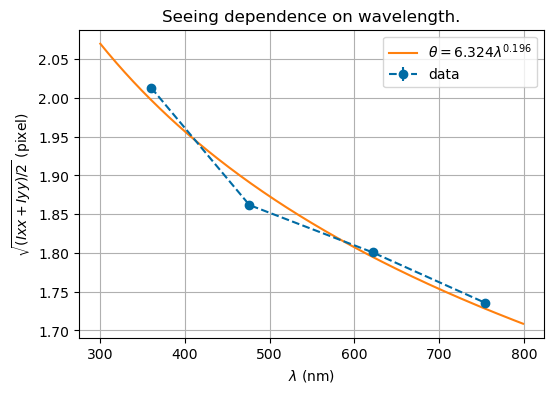

In [48]:
plt.figure(figsize=(6, 4))
plt.errorbar(wavelength, mean_size, std_size/np.sqrt(len(results_table)),
             fmt='o--', label='data')
plt.plot(lamb_grid, fit_size,
         label=r'$\theta = %.3f \lambda^{%.3f}$' % (amplitude, exponent))
plt.title("Seeing dependence on wavelength.")
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel(r'$\sqrt{(Ixx+Iyy)/2}$ (pixel)')
plt.grid()
plt.legend()
plt.show()

In the followign figure, we will over plot the size distributions per band over the plot derived above. The figure contains histograms of the size distributions per band (`u`, `g`, `r`, and `i`) rotated 270 degrees so that their bases are on the left vertical axis. The upper horizontal axis displays the counts of the histograms, ranging from 0 to about 1200 counts. The plot serves a double purpose as the PSF size as function of wavelength data and power-law fit from the plot in the previous cell are also shown here.  

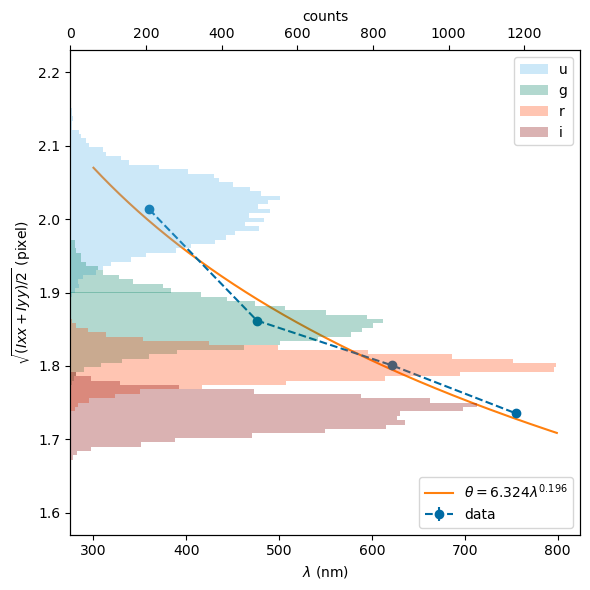

In [49]:
fig, ax1 = plt.subplots(figsize=(6, 6))

color = 'tab:red'
ax1.set_xlabel(r'$\lambda$ (nm)')
ax1.set_ylabel(r'$\sqrt{(Ixx+Iyy)/2}$ (pixel)')
ax1.errorbar(wavelength, mean_size, std_size/np.sqrt(len(results_table)),
             fmt='o--', label='data')
ax1.plot(lamb_grid, fit_size,
         label=r'$\theta = %.3f \lambda^{%.3f}$' % (amplitude, exponent))
ax1.legend(loc='lower right')
ax1.tick_params(axis='y')

ax2 = ax1.twiny()

plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}

ax2.set_xlabel('counts')
plt.hist(results_table['size_u_PSF'], bins=100, range=[1.6, 2.2],
         color=plot_filter_colors['u'], alpha=0.3, label='u',
         orientation="horizontal")
plt.hist(results_table['size_g_PSF'], bins=100, range=[1.6, 2.2],
         color=plot_filter_colors['g'], alpha=0.3, label='g',
         orientation="horizontal")
plt.hist(results_table['size_r_PSF'], bins=100, range=[1.6, 2.2],
         color=plot_filter_colors['r'], alpha=0.3, label='r',
         orientation="horizontal")
plt.hist(results_table['size_i_PSF'], bins=100, range=[1.6, 2.2],
         color=plot_filter_colors['i'], alpha=0.3, label='i',
         orientation="horizontal")
plt.legend()
ax2.tick_params(axis='y')

fig.tight_layout()
plt.show()

### 5. Rho statistics with analysis tools.

In this section we'll use [`lsst.analysys.tools`](https://github.com/lsst/analysis_toolshttps://github.com/lsst/analysis_tools) to calculate the `rho` statistics, a set of two-point correlation functions that measure the spatial relationships between errors in PSF models. If these metrics yield non-zero values, it indicates the presence of systematic errors in the weak lensing shear correlation function. To see how they are defined, see [the analysis tools documentation](https://pipelines.lsst.io/v/daily/py-api/lsst.analysis.tools.actions.vector.CalcRhoStatistics.html#lsst.analysis.tools.actions.vector.CalcRhoStatistics). `lsst.analisys.tools` is a package to create quality assurance (QA) plots and metrics from the outputs of the LSST Science Pipelines. In order to calculate the `rho` statistics, it uses `treecorr`. For an introduction to `analysys_tools`, take a look at [this Jupyter Notebook prepared as a demo for one of the sessions of Rubin's 2022 Project and Community Workshop](https://github.com/lsst-dm/analysis_tools_examples/blob/main/analysis_tools_demo_pcw2022.ipynb).

We will start by defining the `AnalysisTool` structure `RhoStatistics`. As described in the [2020 Rubin PCW `analysis_tools` demo notebook](https://github.com/lsst-dm/analysis_tools_examples/blob/main/analysis_tools_demo_pcw2022.ipynb), `AnalysisTool` is one of the three analysis structures defined in `analysis_tools` that contains multiple `AnalysisAction`s to perform a particular tytpe of analysis.  

In [50]:
atool = RhoStatistics()

There are three types of `AnalysisAction`s or stages: `prep` (for initial filtering of data), `process` (for modyfing the data), and `produce` (for generating final plots of metrics). In the following cells, we will adjust a few configuration parameters from the `prep` and `process` stages.

We'll start with selecting stars with with signal-to-noise ratio (SNR) > 20.

In [51]:
atool.prep.selectors.snSelector.threshold = 20.0

As in a previous section, we can adjust the `treecorr` parameters before calculations, but this time it will be done via `lsst.analysis.tools`.

In [52]:
atool.process.calculateActions.rho.treecorr.nbins = 21
atool.process.calculateActions.rho.treecorr.min_sep = 0.1
atool.process.calculateActions.rho.treecorr.max_sep = 100.0

We need to call `atool.finalize()` after the `atool.prep` and `atool.process` stages are configured.


In [53]:
atool.finalize()

The TAP query in section 3.1 included fields that we did not use in that section, but that will be used in this section. In order to know which entries will be needed by `analysys_tools` to calculate the `rho` statistics, we can look at the input schema of the analysis tool `RhoStatistics`.

In [54]:
input_schema = atool.getInputSchema()
needed_catalog_fields = [name[0] for name in list(atool.getInputSchema())]
print(needed_catalog_fields)

['coord_ra', 'coord_dec', '{band}_ixx', '{band}_iyy', '{band}_ixy', '{band}_ixxPSF', '{band}_iyyPSF', '{band}_ixyPSF', '{band}_psfFlux_flag', '{band}_pixelFlags_saturatedCenter', '{band}_extendedness_flag', 'xy_flag', 'detect_isPatchInner', 'detect_isDeblendedSource', '{band}_psfFlux', '{band}_psfFluxErr', '{band}_extendedness']


Now we are ready to compute the `rho` statistics in the particular band that we have chosen previously (`i`).


We'll start with the `prep` stage in teh followign cell.

In [55]:
prepResults = atool.prep(results_table, band=f"{band}")


Now we will exceute the `process` stage, usingthe results from the `prep` stage: 

In [56]:
processResults = atool.process(prepResults, band=f"{band}")

We can now access the results from `treecorr` for each `rho` statistic in order to examine the values or perform any other operation on them.

In [58]:
print("Mean angular separation:\n", processResults['rho1'].meanr, "\n")
print("Correlation function:\n", processResults['rho1'].xip, "\n")
print("Error in the correlation function:\n", processResults['rho1'].varxip)

Mean angular separation:
 [ 0.12017311  0.1685459   0.23266689  0.32544924  0.44883092  0.62813329
  0.86999208  1.20282896  1.67413031  2.3241002   3.23514482  4.49575909
  6.24488969  8.68315973 12.06400542 16.75441258 23.27609725 32.32357124
 44.88376034 62.2863356  86.25761076] 

Correlation function:
 [-2.52355611e-08  3.59581080e-08  1.78502793e-07 -1.85312869e-08
  1.66952141e-07 -1.09300796e-08  7.95629725e-08  1.95907801e-08
  3.46863274e-08  3.19546135e-08  3.72980681e-08  2.96129858e-08
  2.57193076e-08  4.17031265e-08  2.97849672e-08  3.48310519e-08
  2.87107672e-08  3.61937402e-08  3.44089845e-08  3.52376734e-08
  3.36781249e-08] 

Error in the correlation function:
 [1.61385534e-13 9.82346730e-14 5.05835257e-14 2.84798002e-14
 1.40626399e-14 7.22621795e-15 3.91350603e-15 2.03549322e-15
 1.08277834e-15 5.62739098e-16 2.95487704e-16 1.55025786e-16
 8.06553200e-17 4.24496633e-17 2.23005002e-17 1.18095412e-17
 6.35893513e-18 3.48539955e-18 1.96744389e-18 1.15570814e-18
 7.352

Let's now plot the `rho` statistics using `analysis_tools`: 

By default, the rho statistics are plotted on a symmetric log scale.
The threshold where the switch happens from linear to log scale can be set as follows.

In [59]:
atool.produce.plot.rhoPlots["rho3"].yLinThresh = 1e-8

The following cell will produce six plots of the `rho` statistics. For other possible configuration options, [see the documentation](https://pipelines.lsst.io/v/daily/py-api/lsst.analysis.tools.actions.plot.XYPlot.html#lsst.analysis.tools.actions.plot.XYPlot). The vertical axis of each plot displays the particular `rho` statistic, and the horizontal axis, the separation in arcminutes, ranging from about 0.01 to 100 arcminutes in a logaritthmic axis.

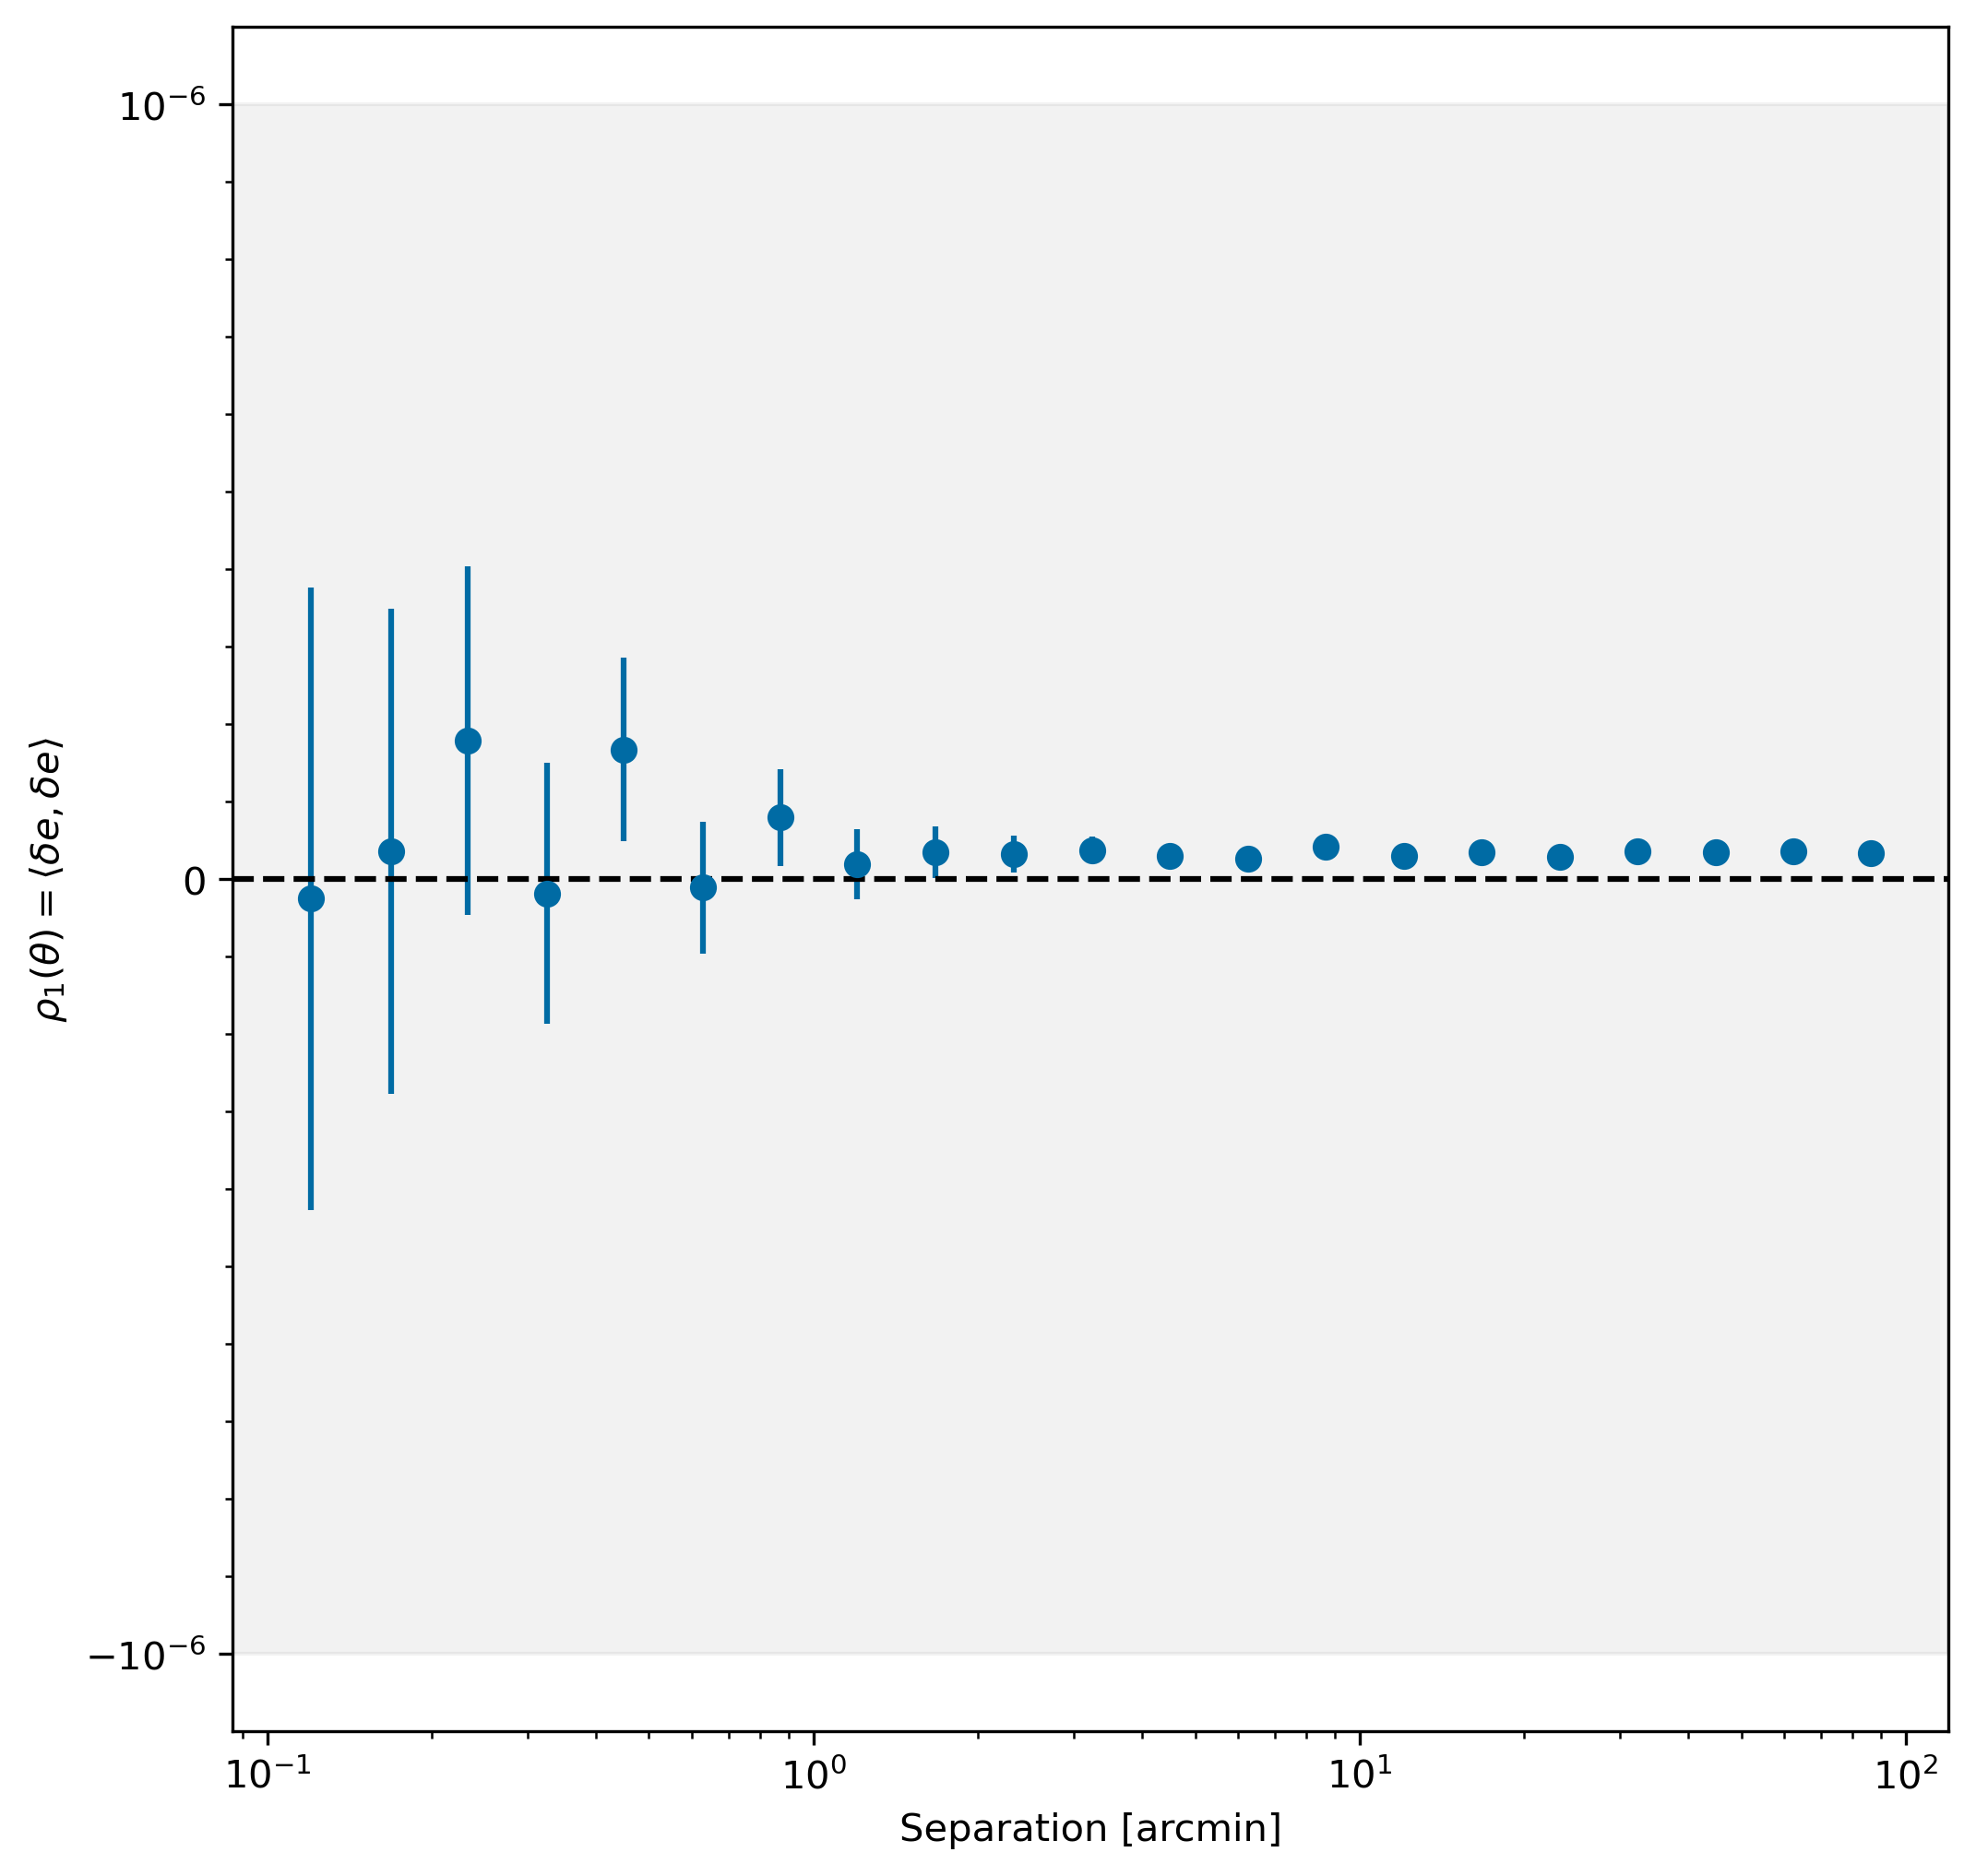

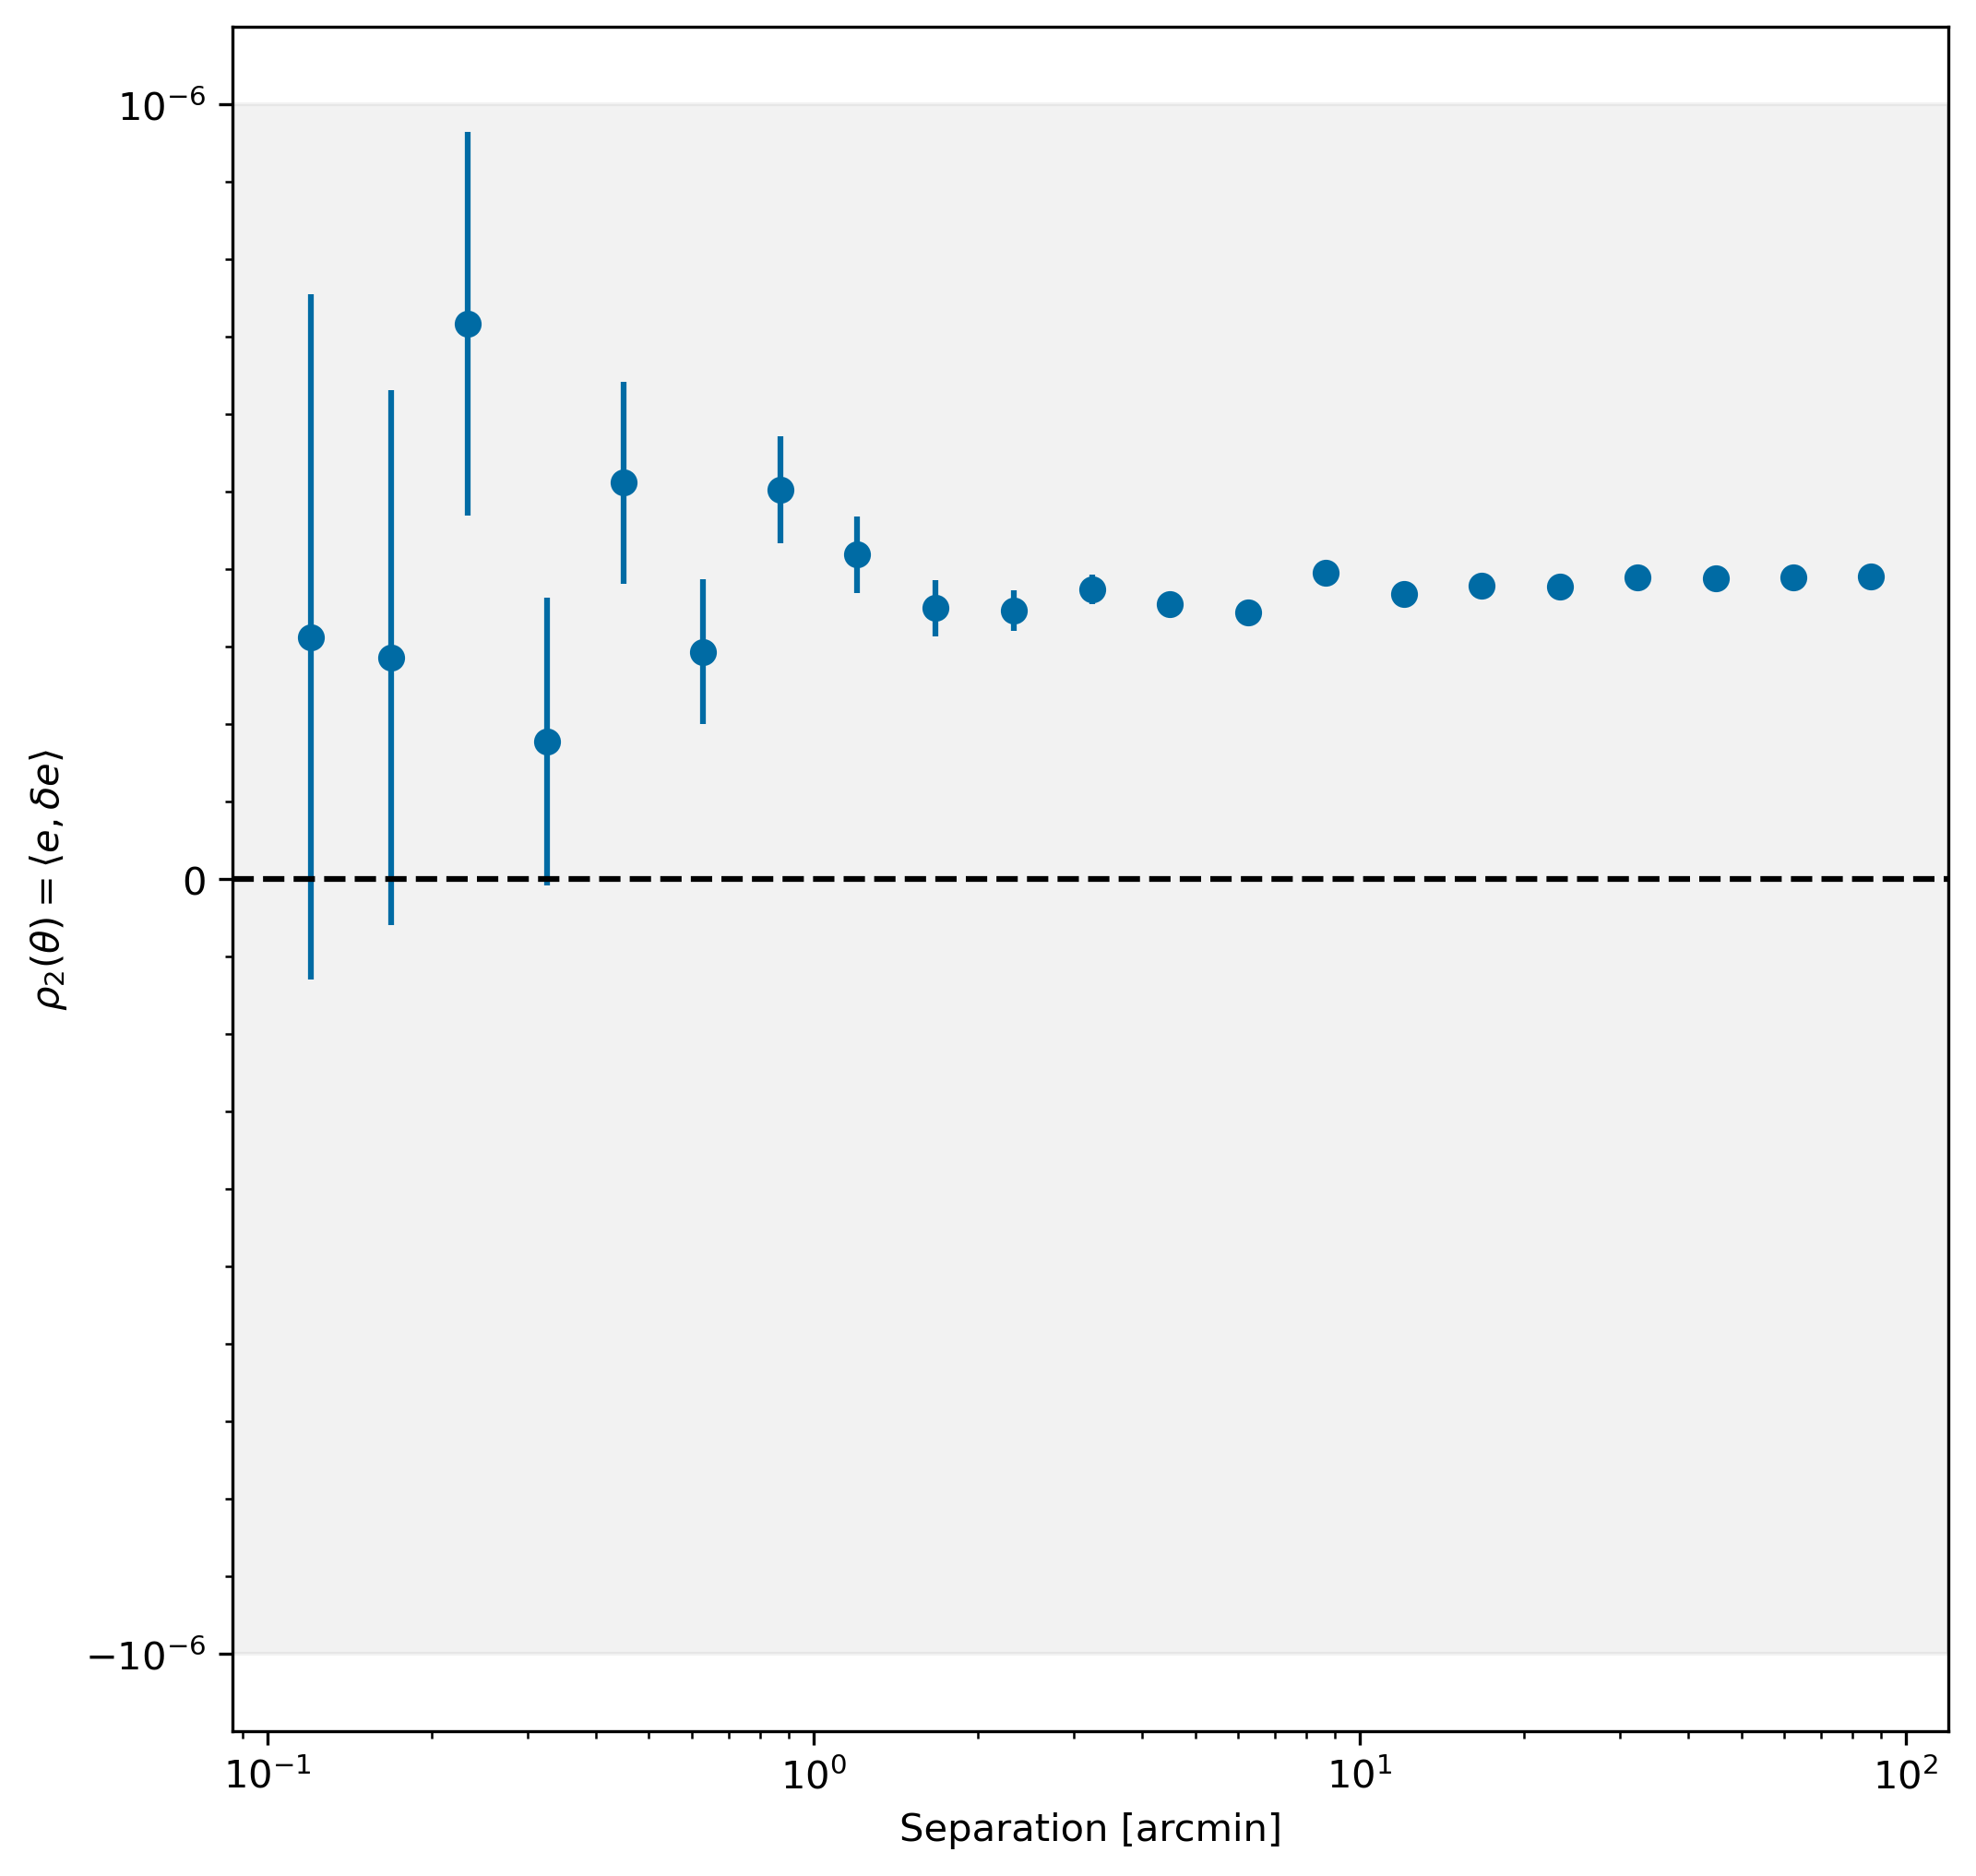

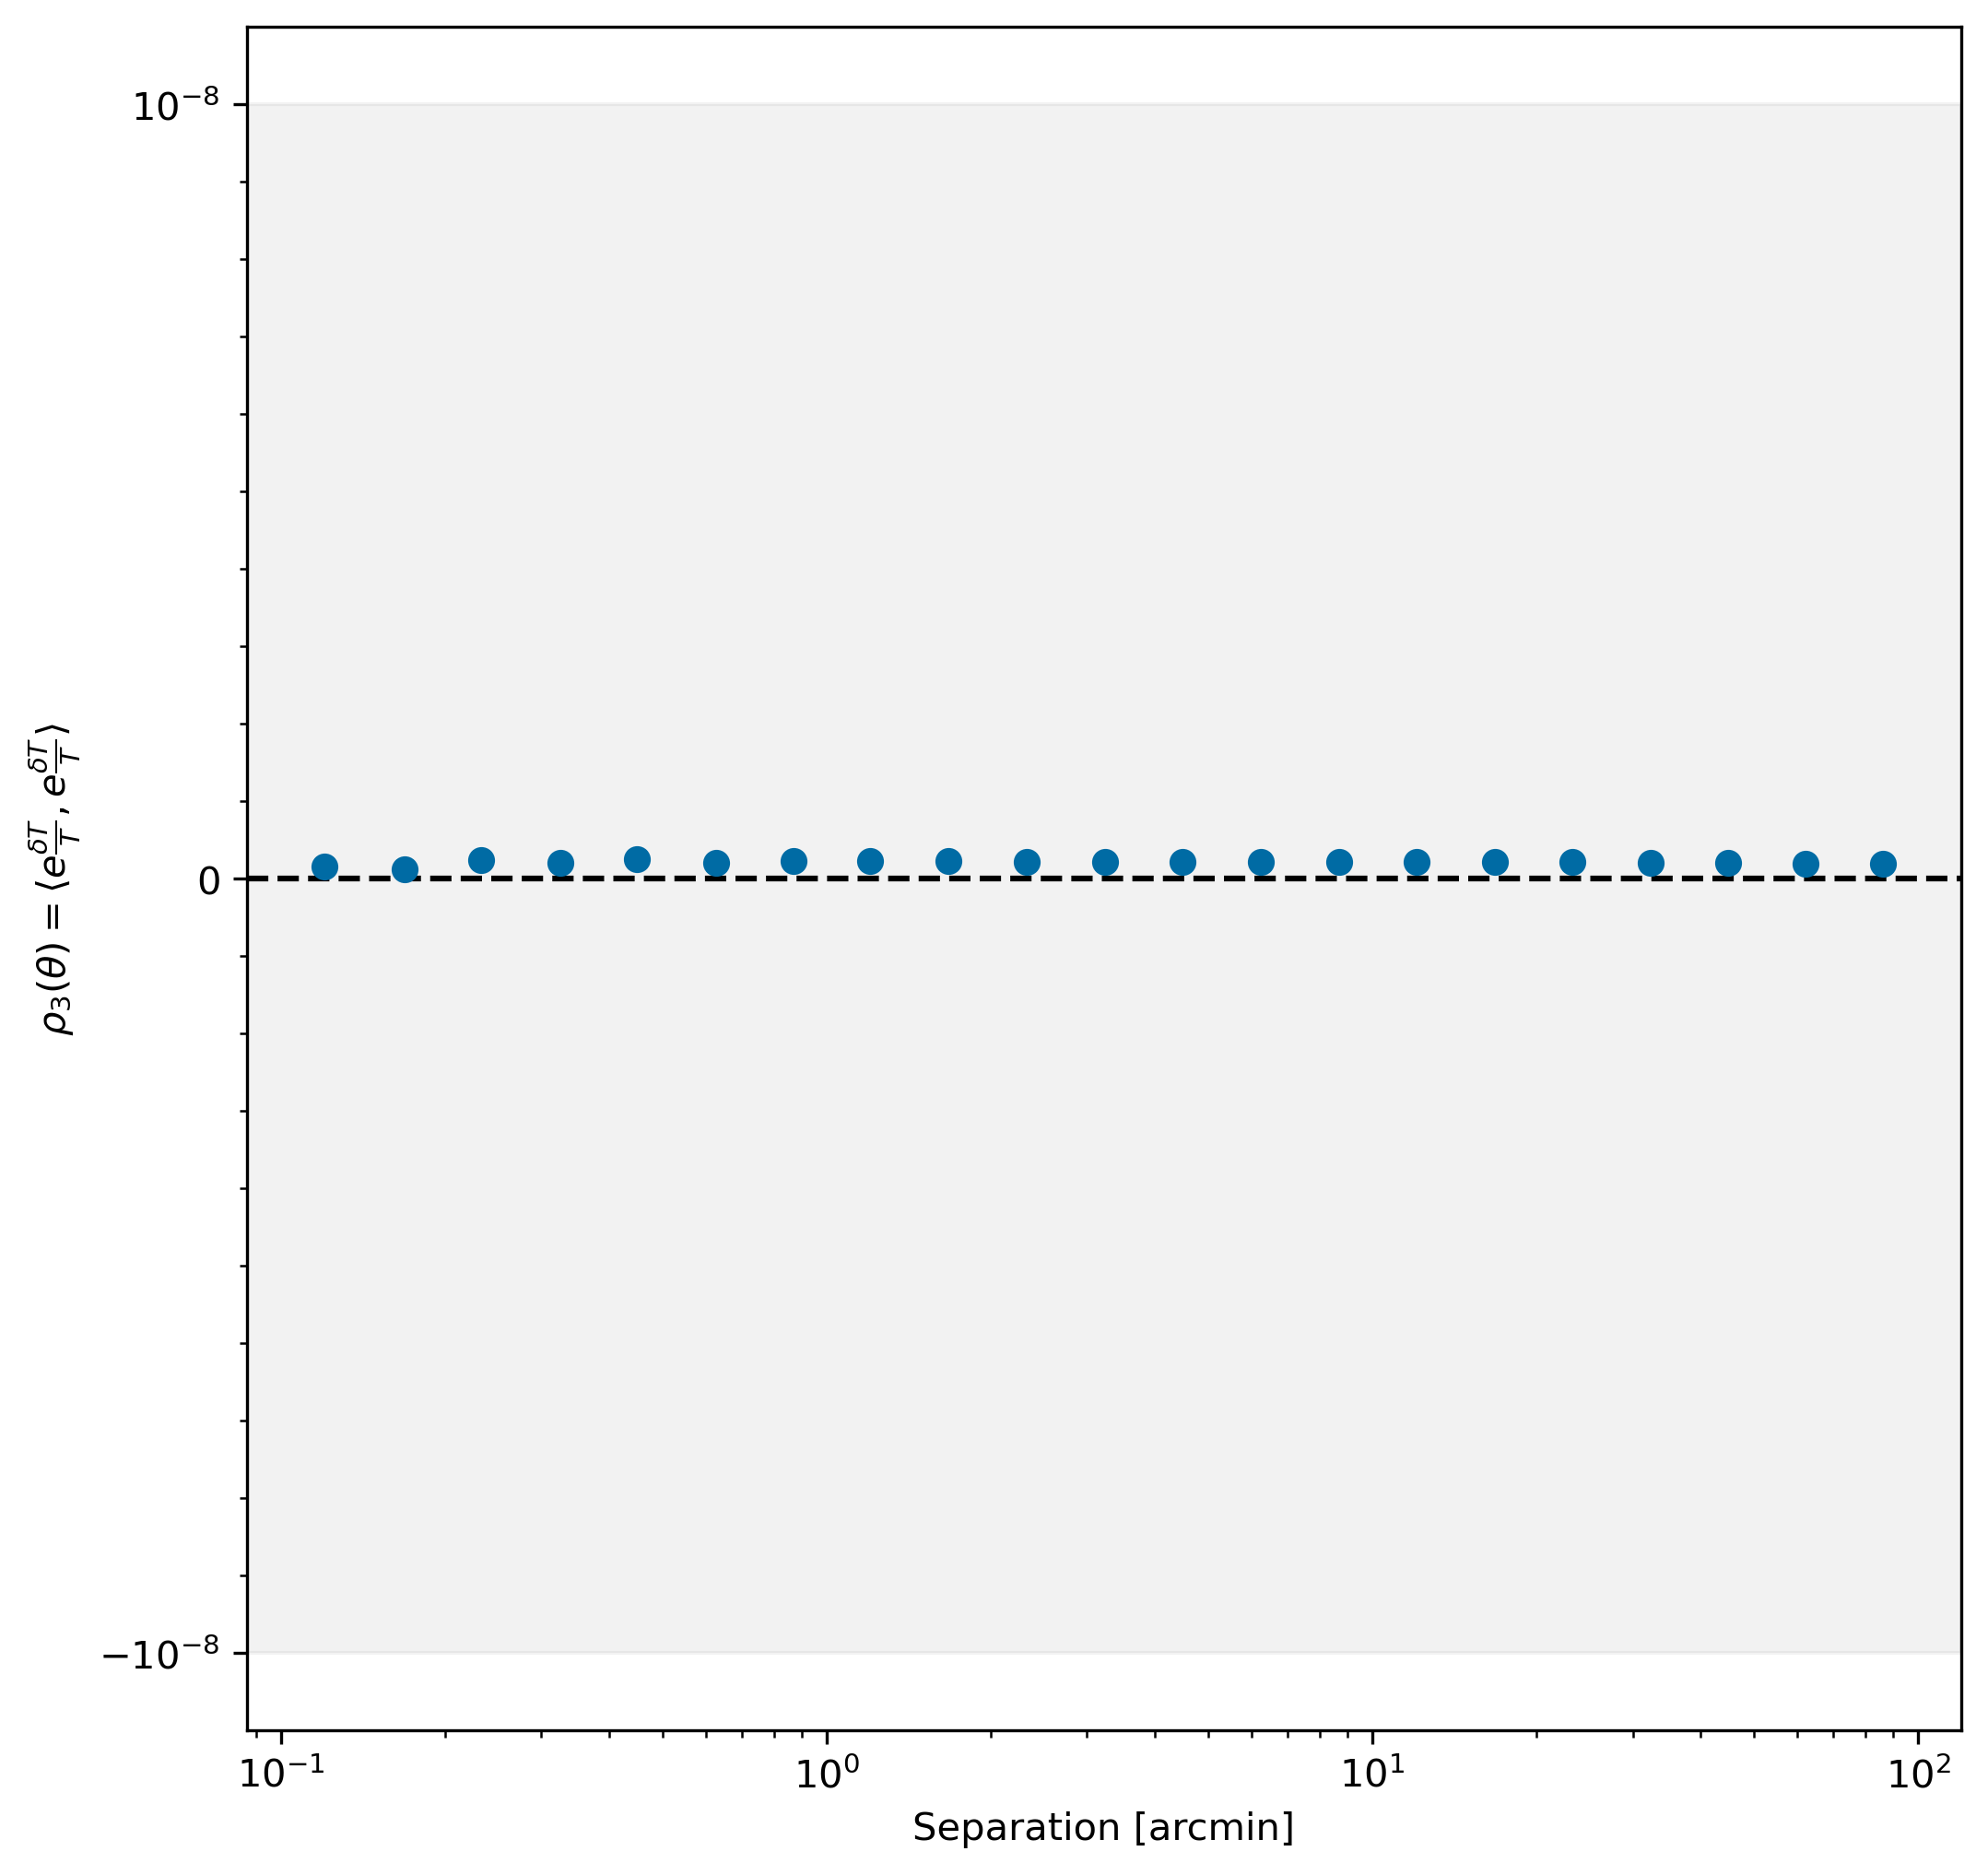

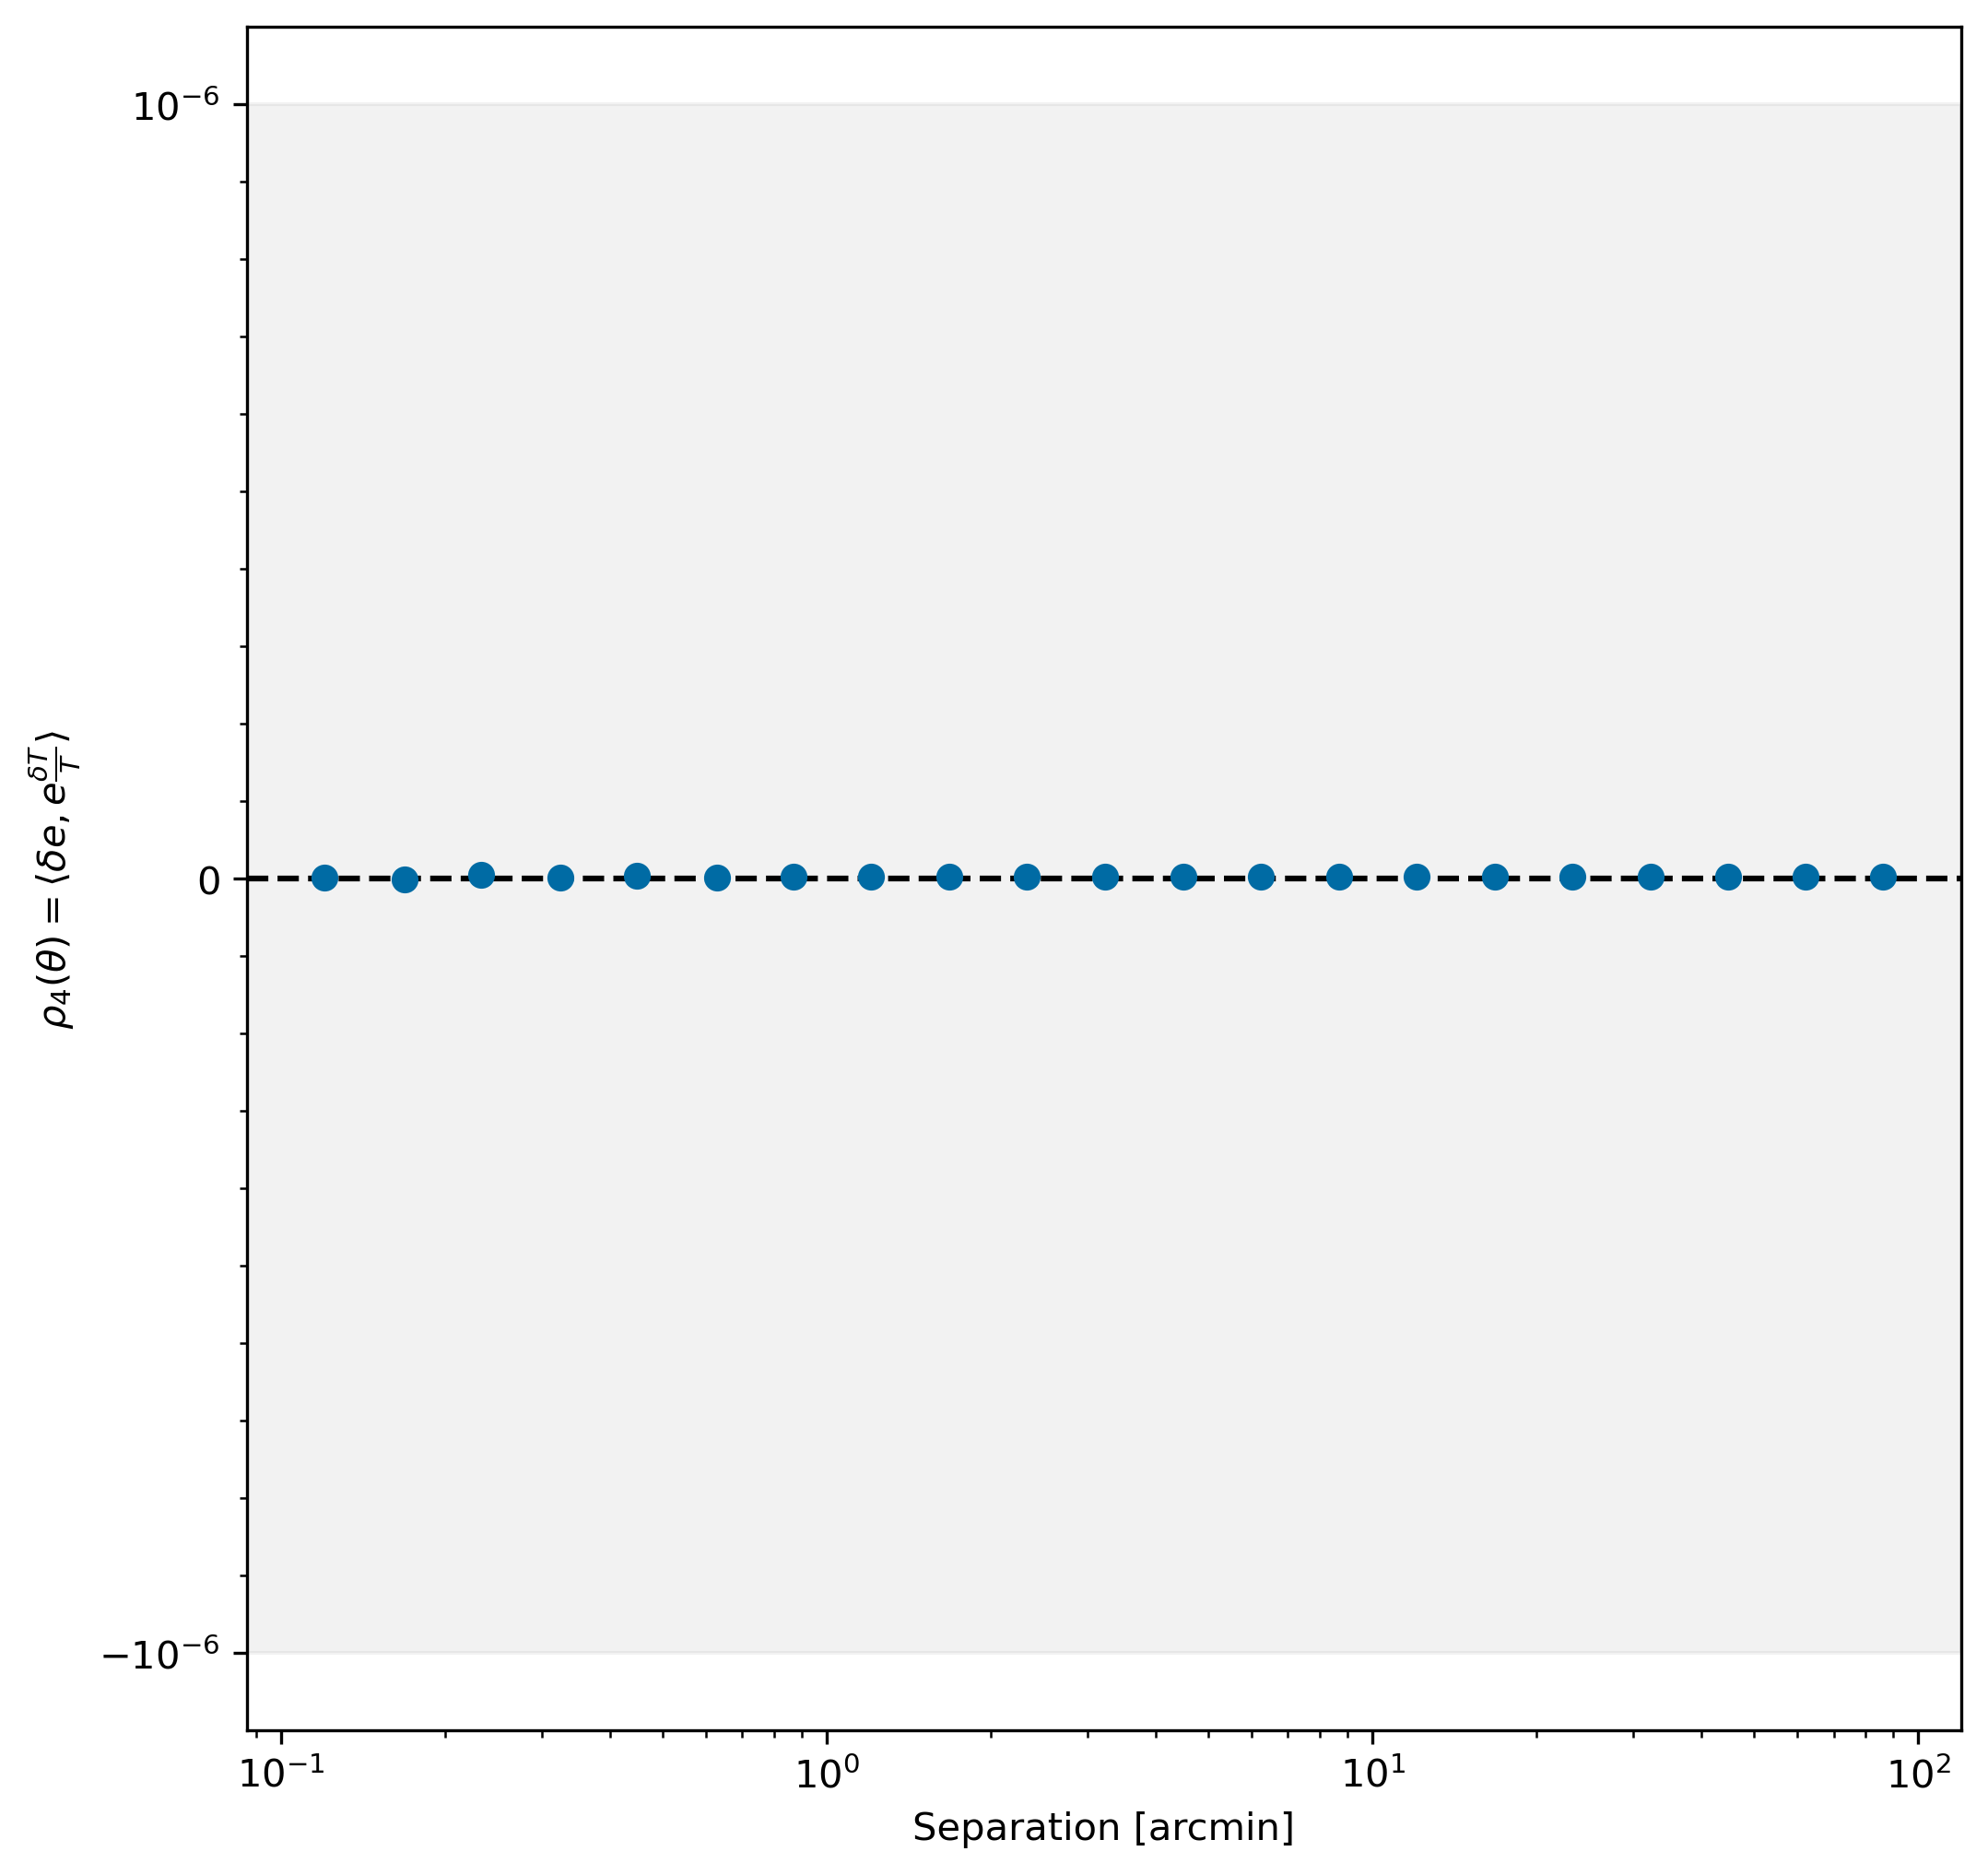

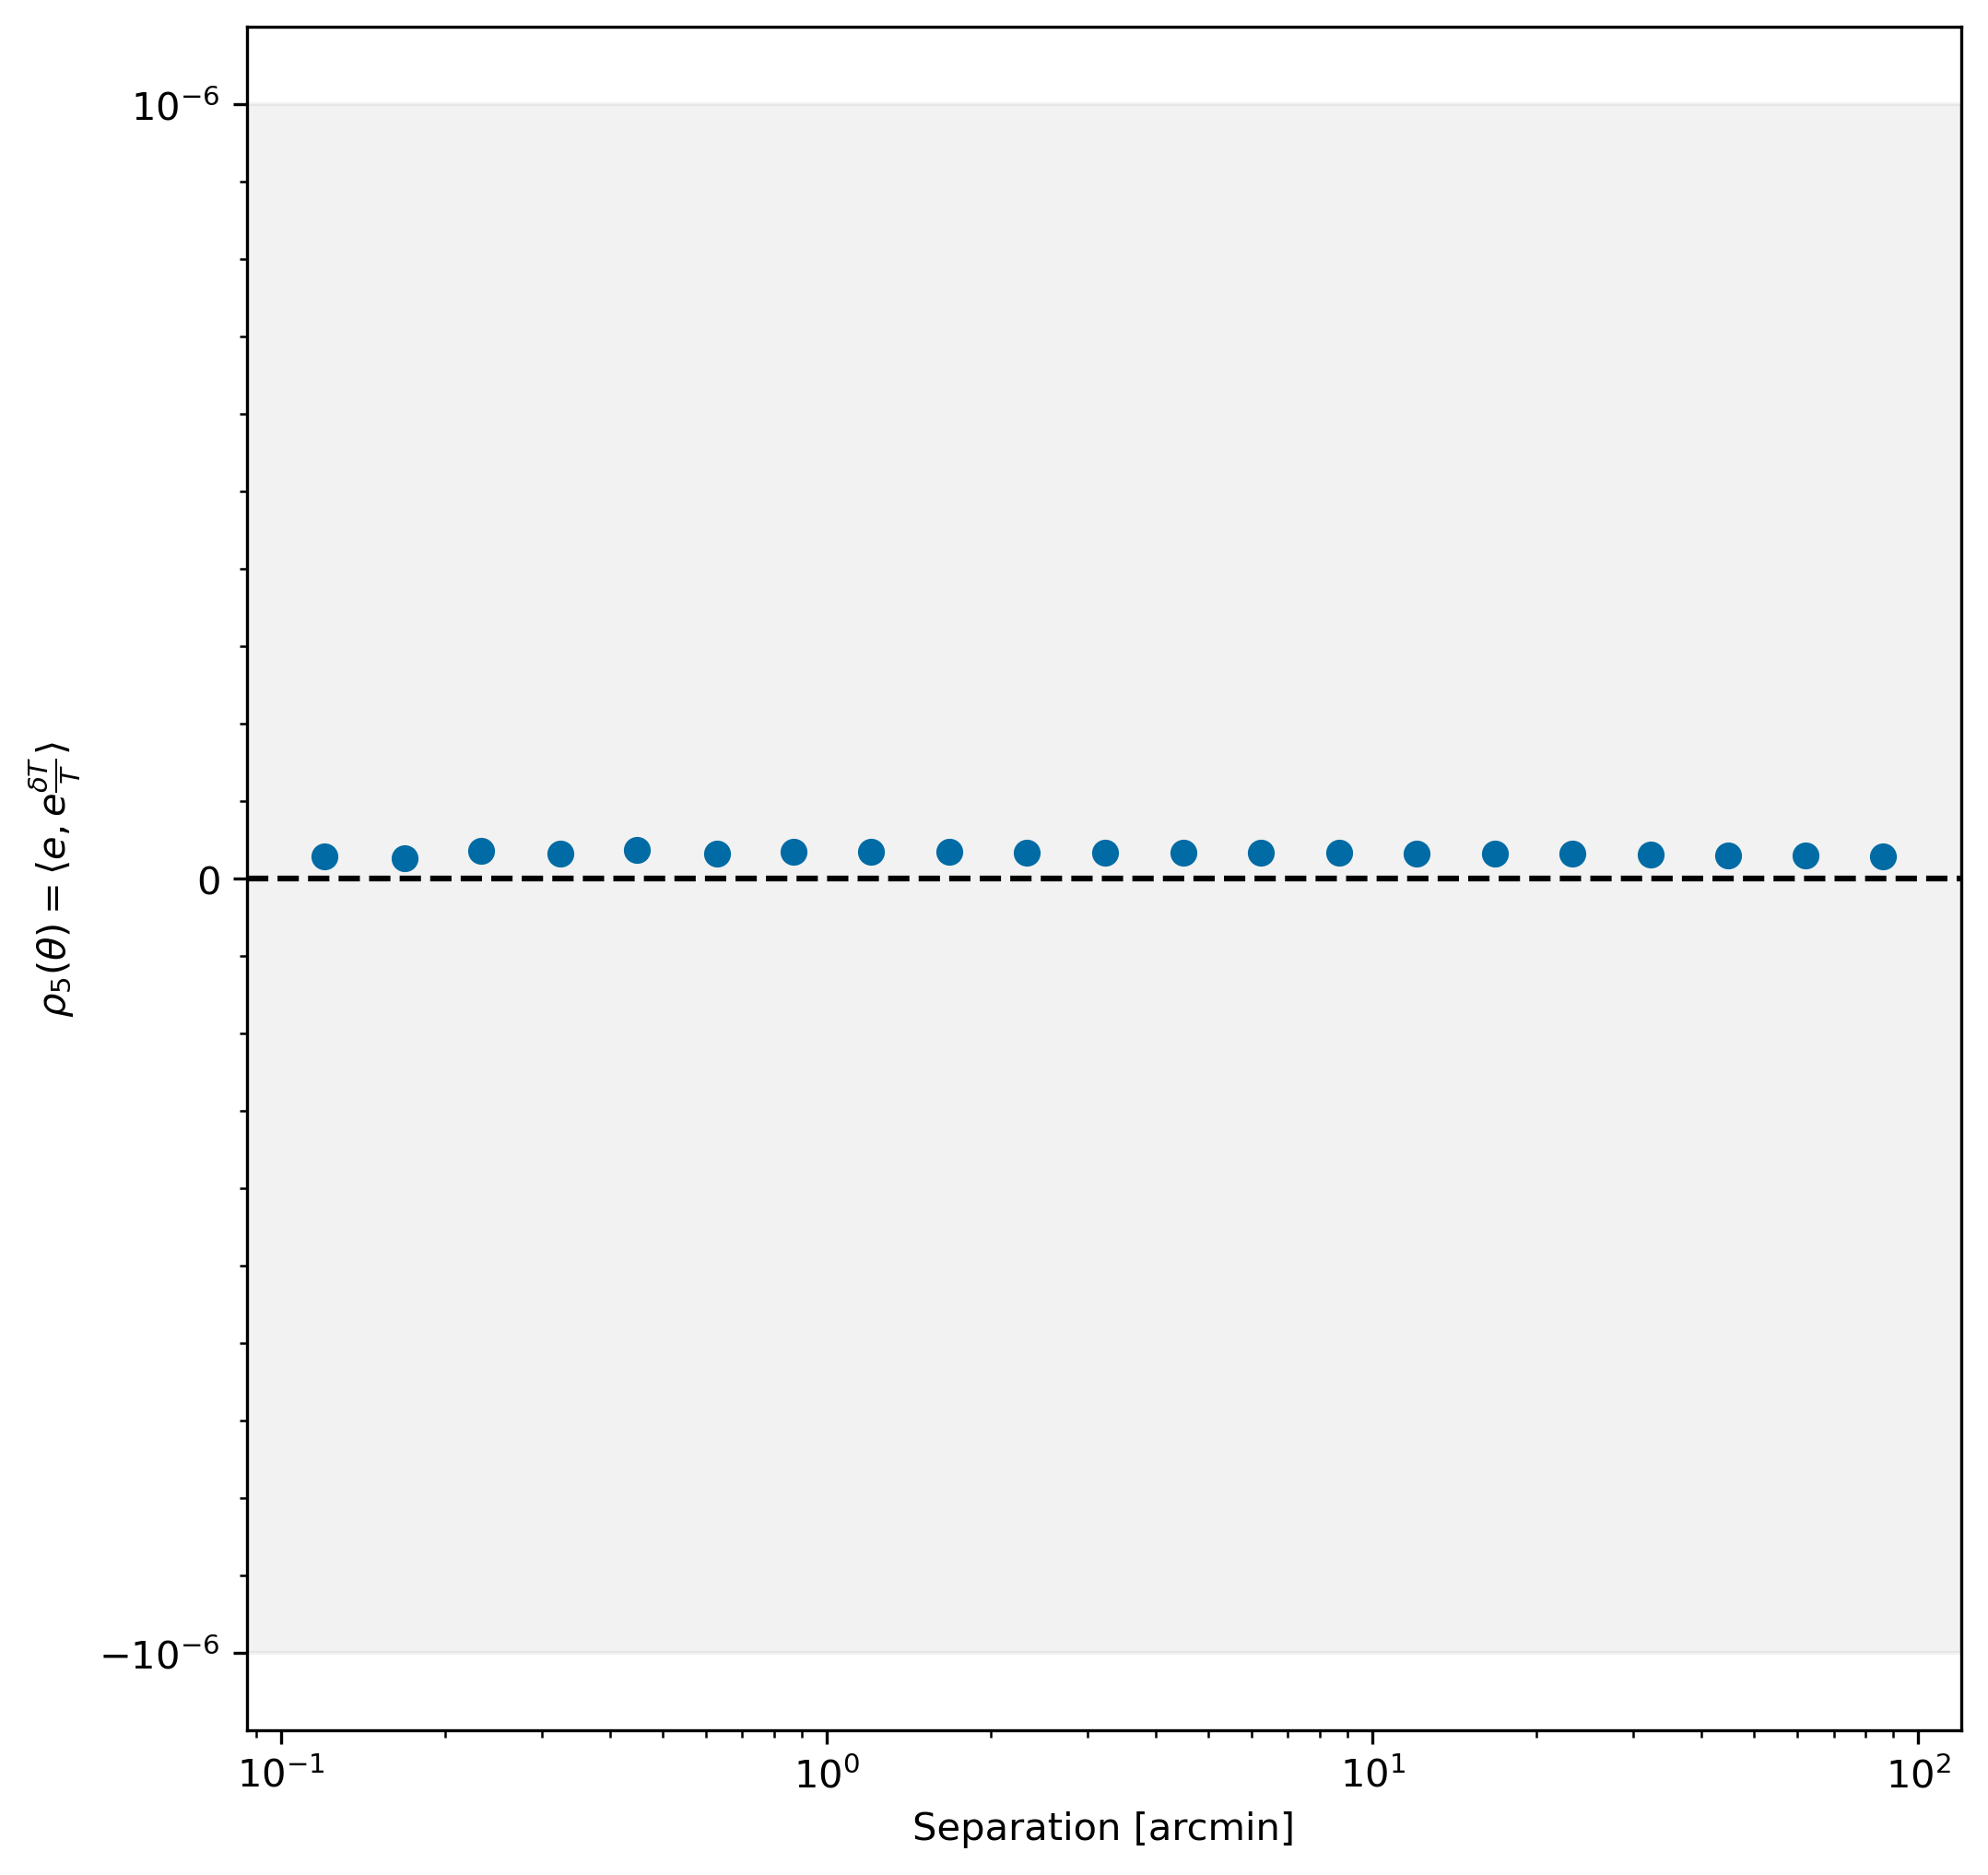

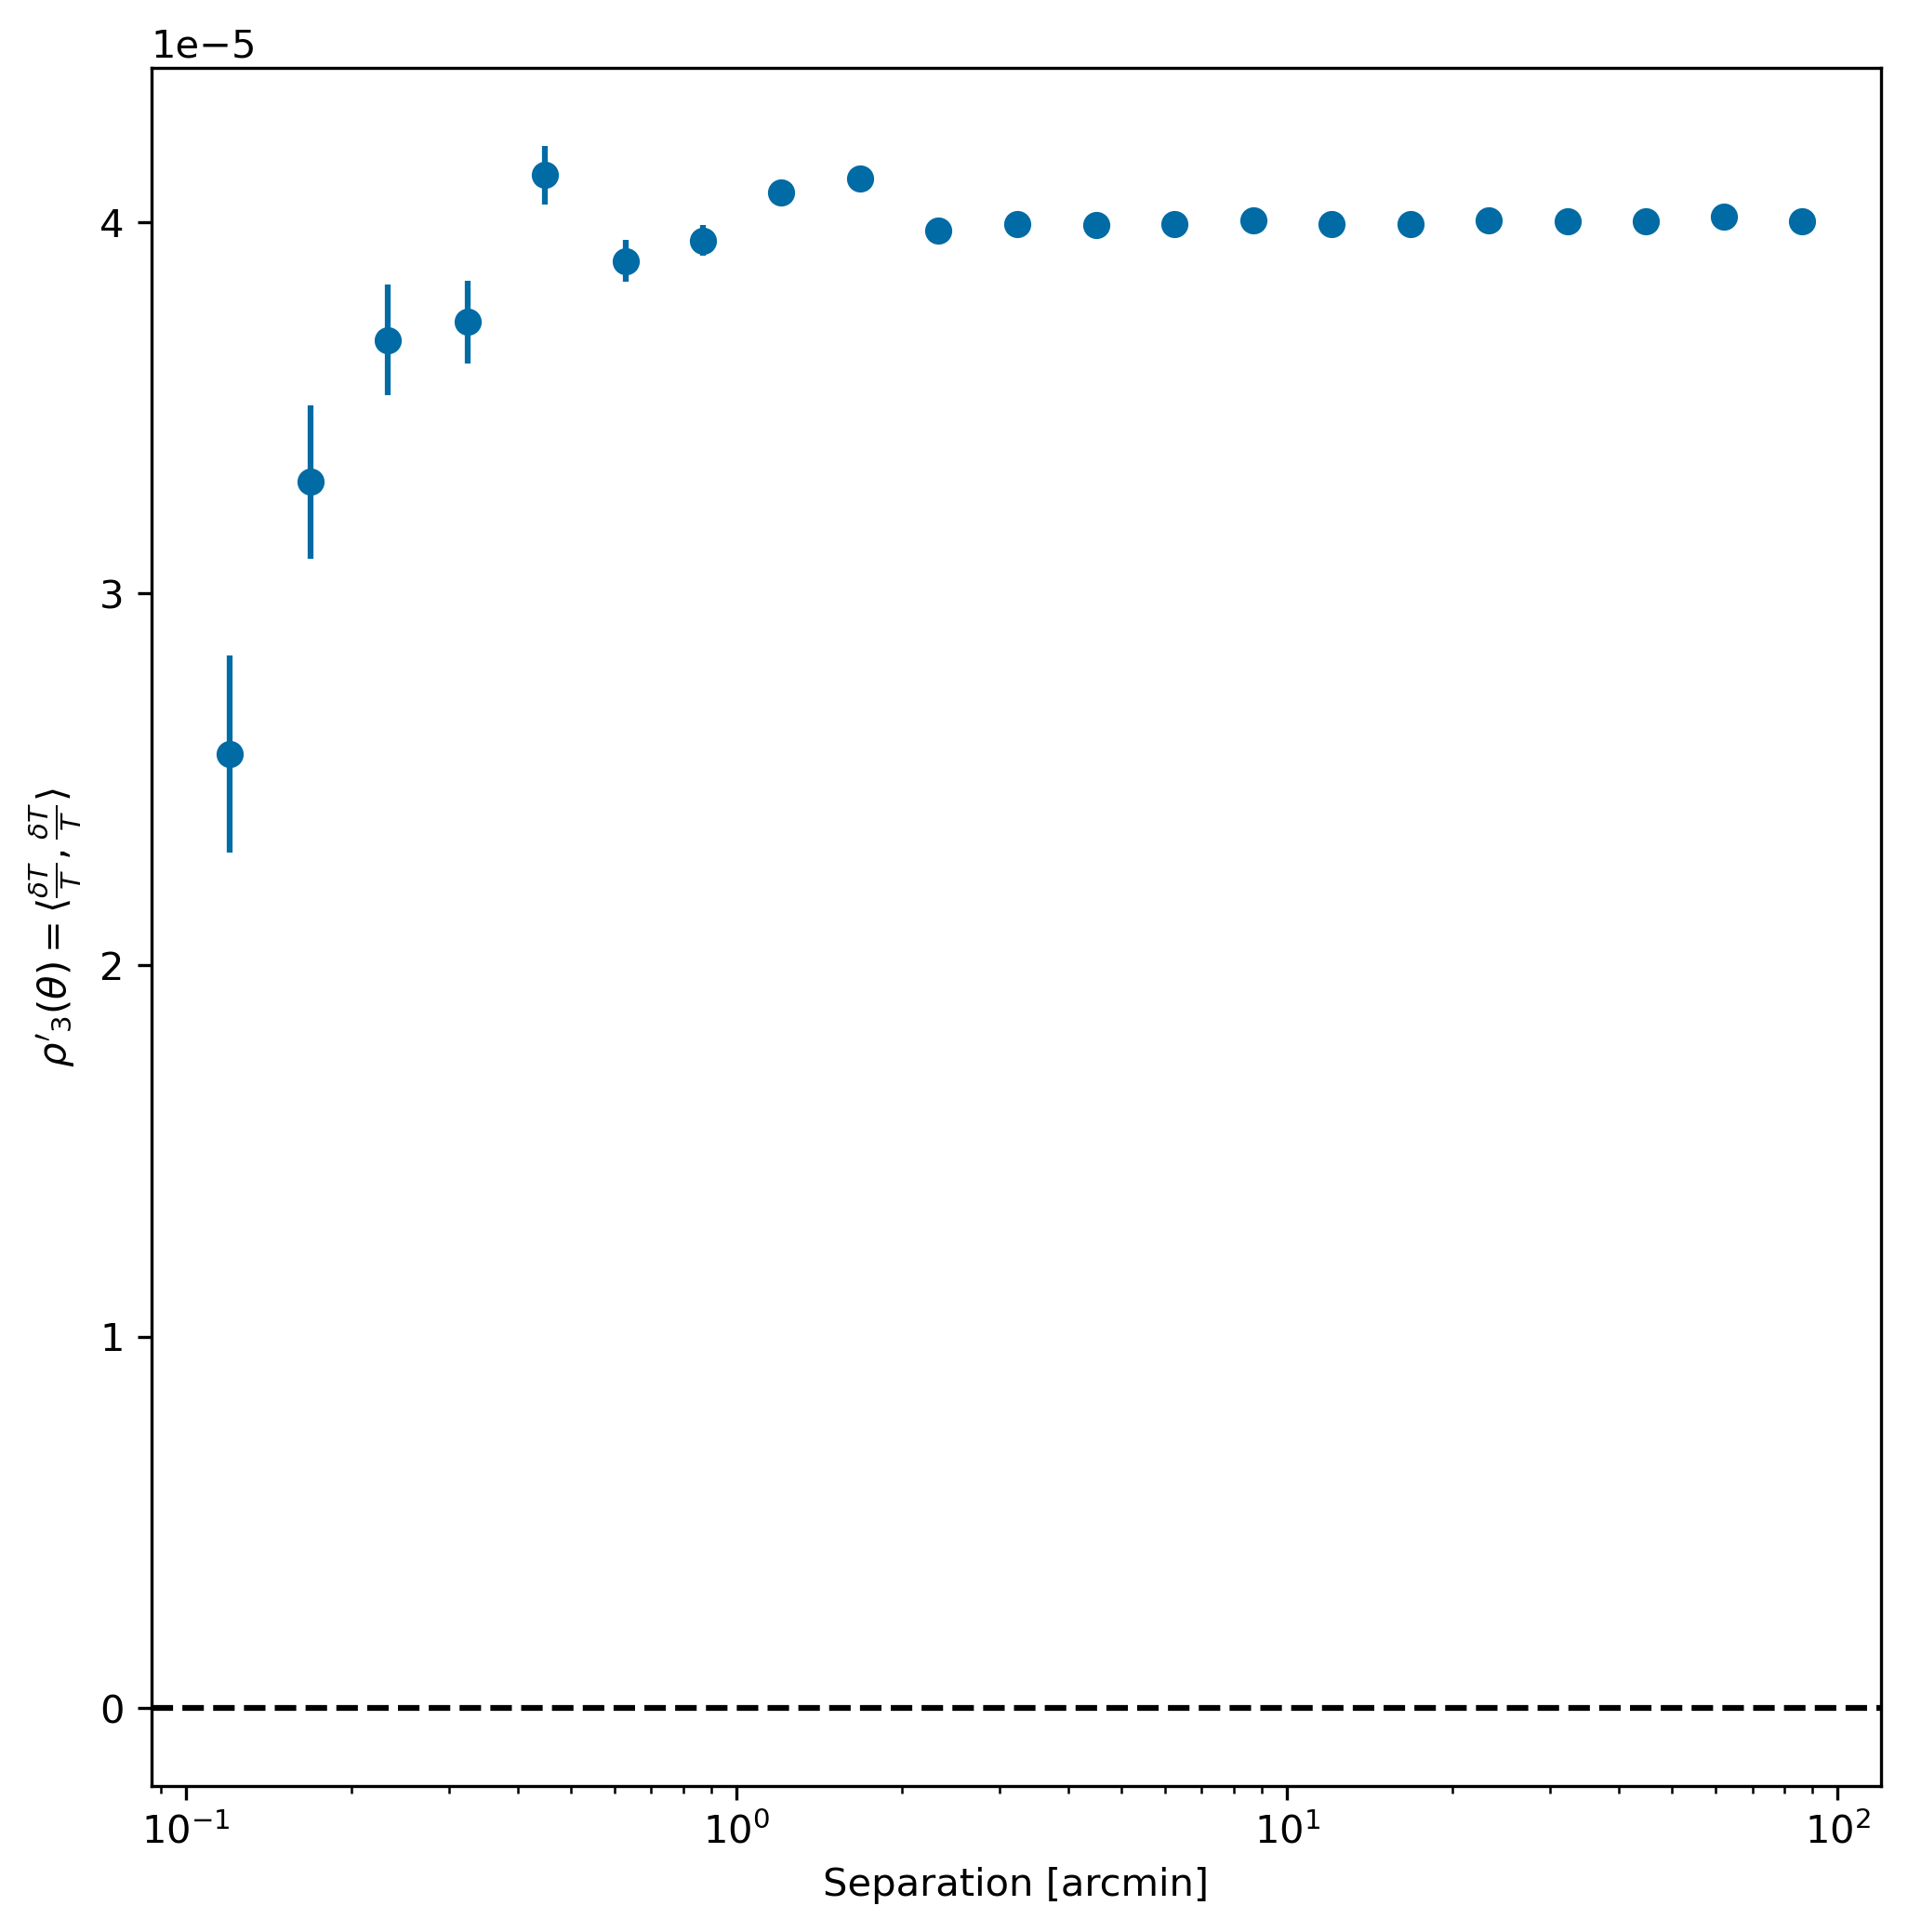

In [60]:
produceResults = atool.produce(processResults, band=f"{band}", skymap=None)

As explained in [Jarvis et al. 2020](https://arxiv.org/pdf/2011.03409.pdf),  `rho1` (ρ1), `rho3` (ρ3), and `rho4` (ρ4), represent direct systematic errors in `xi+` (ξ+) with a leading coefficient of order unity.  The `rho2` (ρ2) and `rho5` (ρ5) describe the amount of "PSF leakage" that occurs during the shear measurement process. 

The DC2 area is a relatively small area which does not show much of PSF variations, and the `rho` statistics that we have obtained in the  previous examples (for the `i` band, as the `rho` statistics may vary with band) are relatively small and well-behaved. For comparison, Fig. 26 of the [HSC Y3 shape catalog](https://arxiv.org/pdf/2107.00136.pdfhttps://arxiv.org/pdf/2107.00136.pdf) and Fig. 12 of the [DES Y3 shape catalog analyses](https://arxiv.org/pdf/2011.03409.pdfhttps://arxiv.org/pdf/2011.03409.pdf) show `rho` statistics obtained from on-sky data from each respectice galaxy survey (HSC Survey and DES), along with the requirements that each `rho` statistics should satisfy (e.g, Eq. 37 of [Li et al. 2021](https://arxiv.org/pdf/2107.00136.pdfhttps://arxiv.org/pdf/2107.00136.pdf)) in order to conclude that there are not significant PSF modeling systematic errors that will impact the scientific cosmic shear goals.   


### Excercises for the learner

#### Section 2:

-In the `radialAverageAndFit` function of the `ImageExamine` class, use a different functional form instead of a Gaussian (such as Moffat, see Eq. 3.6 of [Jarvis et al. 2020](https://arxiv.org/pdf/2011.03409.pdf)).

-Calculate other statistics for the one-dimensional PSF radial profiles such as skewness and kurtosis.


#### Section 3:
-Calculate the PSF ellipticity (defined in term sof the second moments as in Eq. 7.5 of [Jarvis et al. 2020](https://arxiv.org/pdf/2011.03409.pdf) and make similar plots to the one sin section 3.2

-Modify the query in section 3.1 such that not only point sources are returned, but also extended sources. Make a size-magnitude diagram (using, for example, the definition of size in section 3.2) to identify the locus of points with constant size, which reporesents the objects that are likely to be stars in the process of star-galaxy separation. Compare to Fig. 3 in  [Jarvis et al. 2020](https://arxiv.org/pdf/2011.03409.pdf).

#### Section 5: 
-Modify the query in section 3.1 such that the required catalog fields (according to the input schema for the `RhoStatistics` of `analysis_tools`) are retrieved in order to calculate the `rho` statistics in a different band. In particular, see what the `rho` statistics look like in the `g` band. Chromatics effects, such as Differential Chromatic Refraction (DCR), tend to have a larger impact in the blue bands, and the `rho` statistics are used as a diagnostic tool to decide whether or not to include observations in these bluer bands in a weak lensing analysis (see the discussion in section 7.4 of [Jarvis et al. 2020](https://arxiv.org/pdf/2011.03409.pdf)).
